## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = cids_dm + cids_em

In [3]:
from_DB = True
path_to_feather = "..//..//data//feathers//"
cats = ['INFTAVG', 'INFTEFF', 'INFE1Y', 'INFE2Y', 'INFE5Y']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfm = dbi.get_series_values(category=cats, cross_section=cids, frequency="m")  # import grade 1 vintages
    dfm.to_feather(f'{path_to_feather}dfm_infe.ftr')
else:
    dfm = pd.read_feather(f'{path_to_feather}dfm_infe.ftr')

In [4]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13431927 entries, 0 to 13431926
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cross_section     object 
 1   category_code     object 
 2   adjustment        object 
 3   transformation    object 
 4   release_date      object 
 5   observation_date  object 
 6   value             float64
 7   grading           object 
dtypes: float64(1), object(7)
memory usage: 819.8+ MB


## Functions

In [5]:
def countmap(cat, start_year, figsize=(12, 12), trueVin = False):
    dfx = dfm[dfm['category_code']==cat]
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    xids = np.sort(dfx['cross_section'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for cid in xids:
        dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(cat + ': Vintage lengths for last (available) release in year ', y = 1.1, fontsize=14)

In [6]:
def revlines(df, pots, ncols=4, size = (16, 16)):
    
    xids = np.sort(df['cross_section'].unique())
    
    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    fig, axes = plt.subplots(nrows=math.ceil(len(xids)/ncols), ncols=ncols, sharex=True, figsize=size)

    for i in range(len(xids)):
        cid = xids[i]
        dfc = df.query('cross_section == @cid')
        releases = dfc['release_date'].unique()
        selected_releases = [None] * len(pots)
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            selected_releases[p] = release
        dfcx = dfc[dfc['release_date'].isin(selected_releases)]
        axe = axes[math.floor(i / ncols), (i % ncols)]
        sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                     hue="release_date", palette=colors, ax=axe)
        axe.set(title=cid, ylabel="", xlabel="")

    plt.show()

In [7]:
def make_boxes(df, val, title, ylab):    
    sns.set(style="whitegrid")
    fg = sns.catplot(
        data=df, kind="box", height=6, aspect=2.5,
        x="cross_section", y=val, hue="category_code",
        palette="Paired"
    )
    fg.despine(left=True)
    fg.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
    fg.fig.suptitle(title, y = 1.03, fontsize=14)
    fg.set_axis_labels("", ylab)
    plt.show()

## Average inflation targets

### Vintage availability

In [8]:
cids_ifav = set(dfm.loc[dfm['category_code']=='INFTAVG', 'cross_section'].unique())  # set of cross-sections in downloaded df
print('Cross sections outside the regular global set: ', cids_ifav - set(cids)) 
print('Cross sections missing from regular global set: ', set(cids) - cids_ifav) 

Cross sections outside the regular global set:  set()
Cross sections missing from regular global set:  {'HKD'}


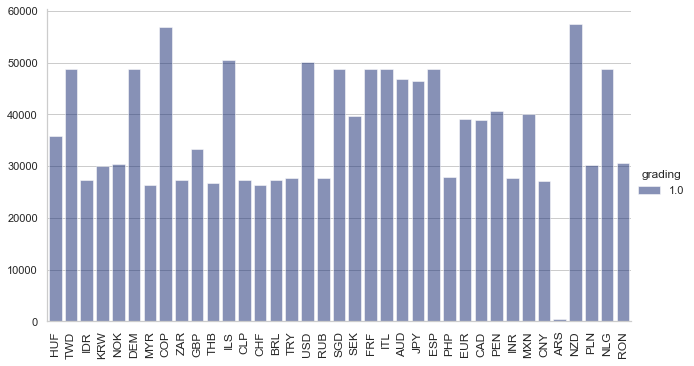

In [9]:
sns.set_theme(style='whitegrid')
fg = sns.catplot(data=dfm[dfm['category_code']=='INFTAVG'], kind='count', hue='grading', order=cids_ifav, 
                 x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
fg.set_xticklabels(rotation=90, size=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

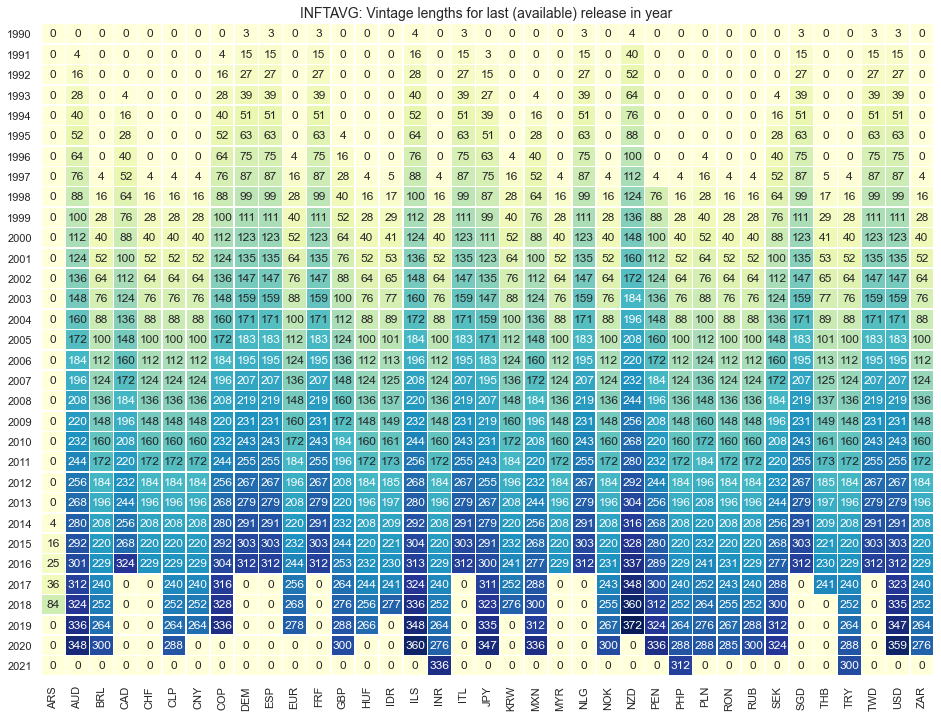

In [10]:
countmap('INFTAVG', 1990, (16, 12))
plt.show

### Vintage consistency

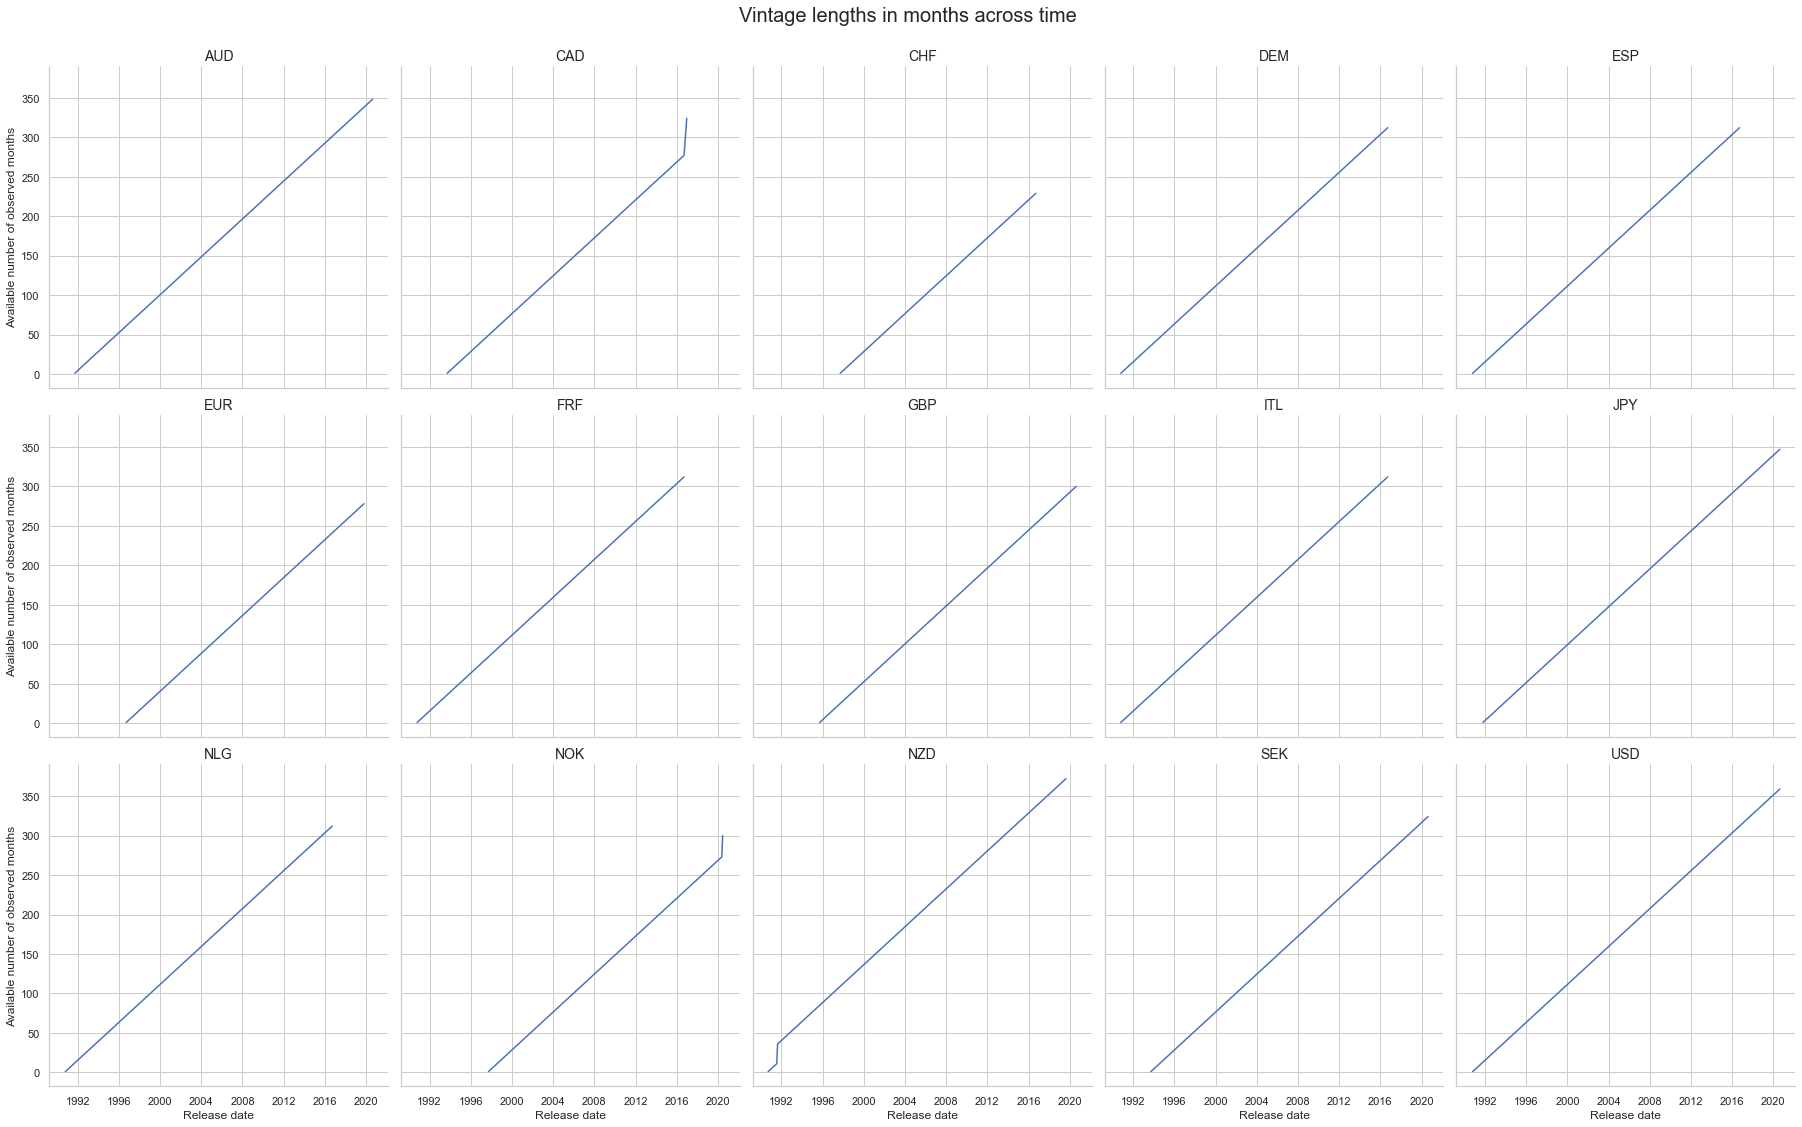

In [11]:
cidx = cids_ifav & set(cids_dm)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFTAVG'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

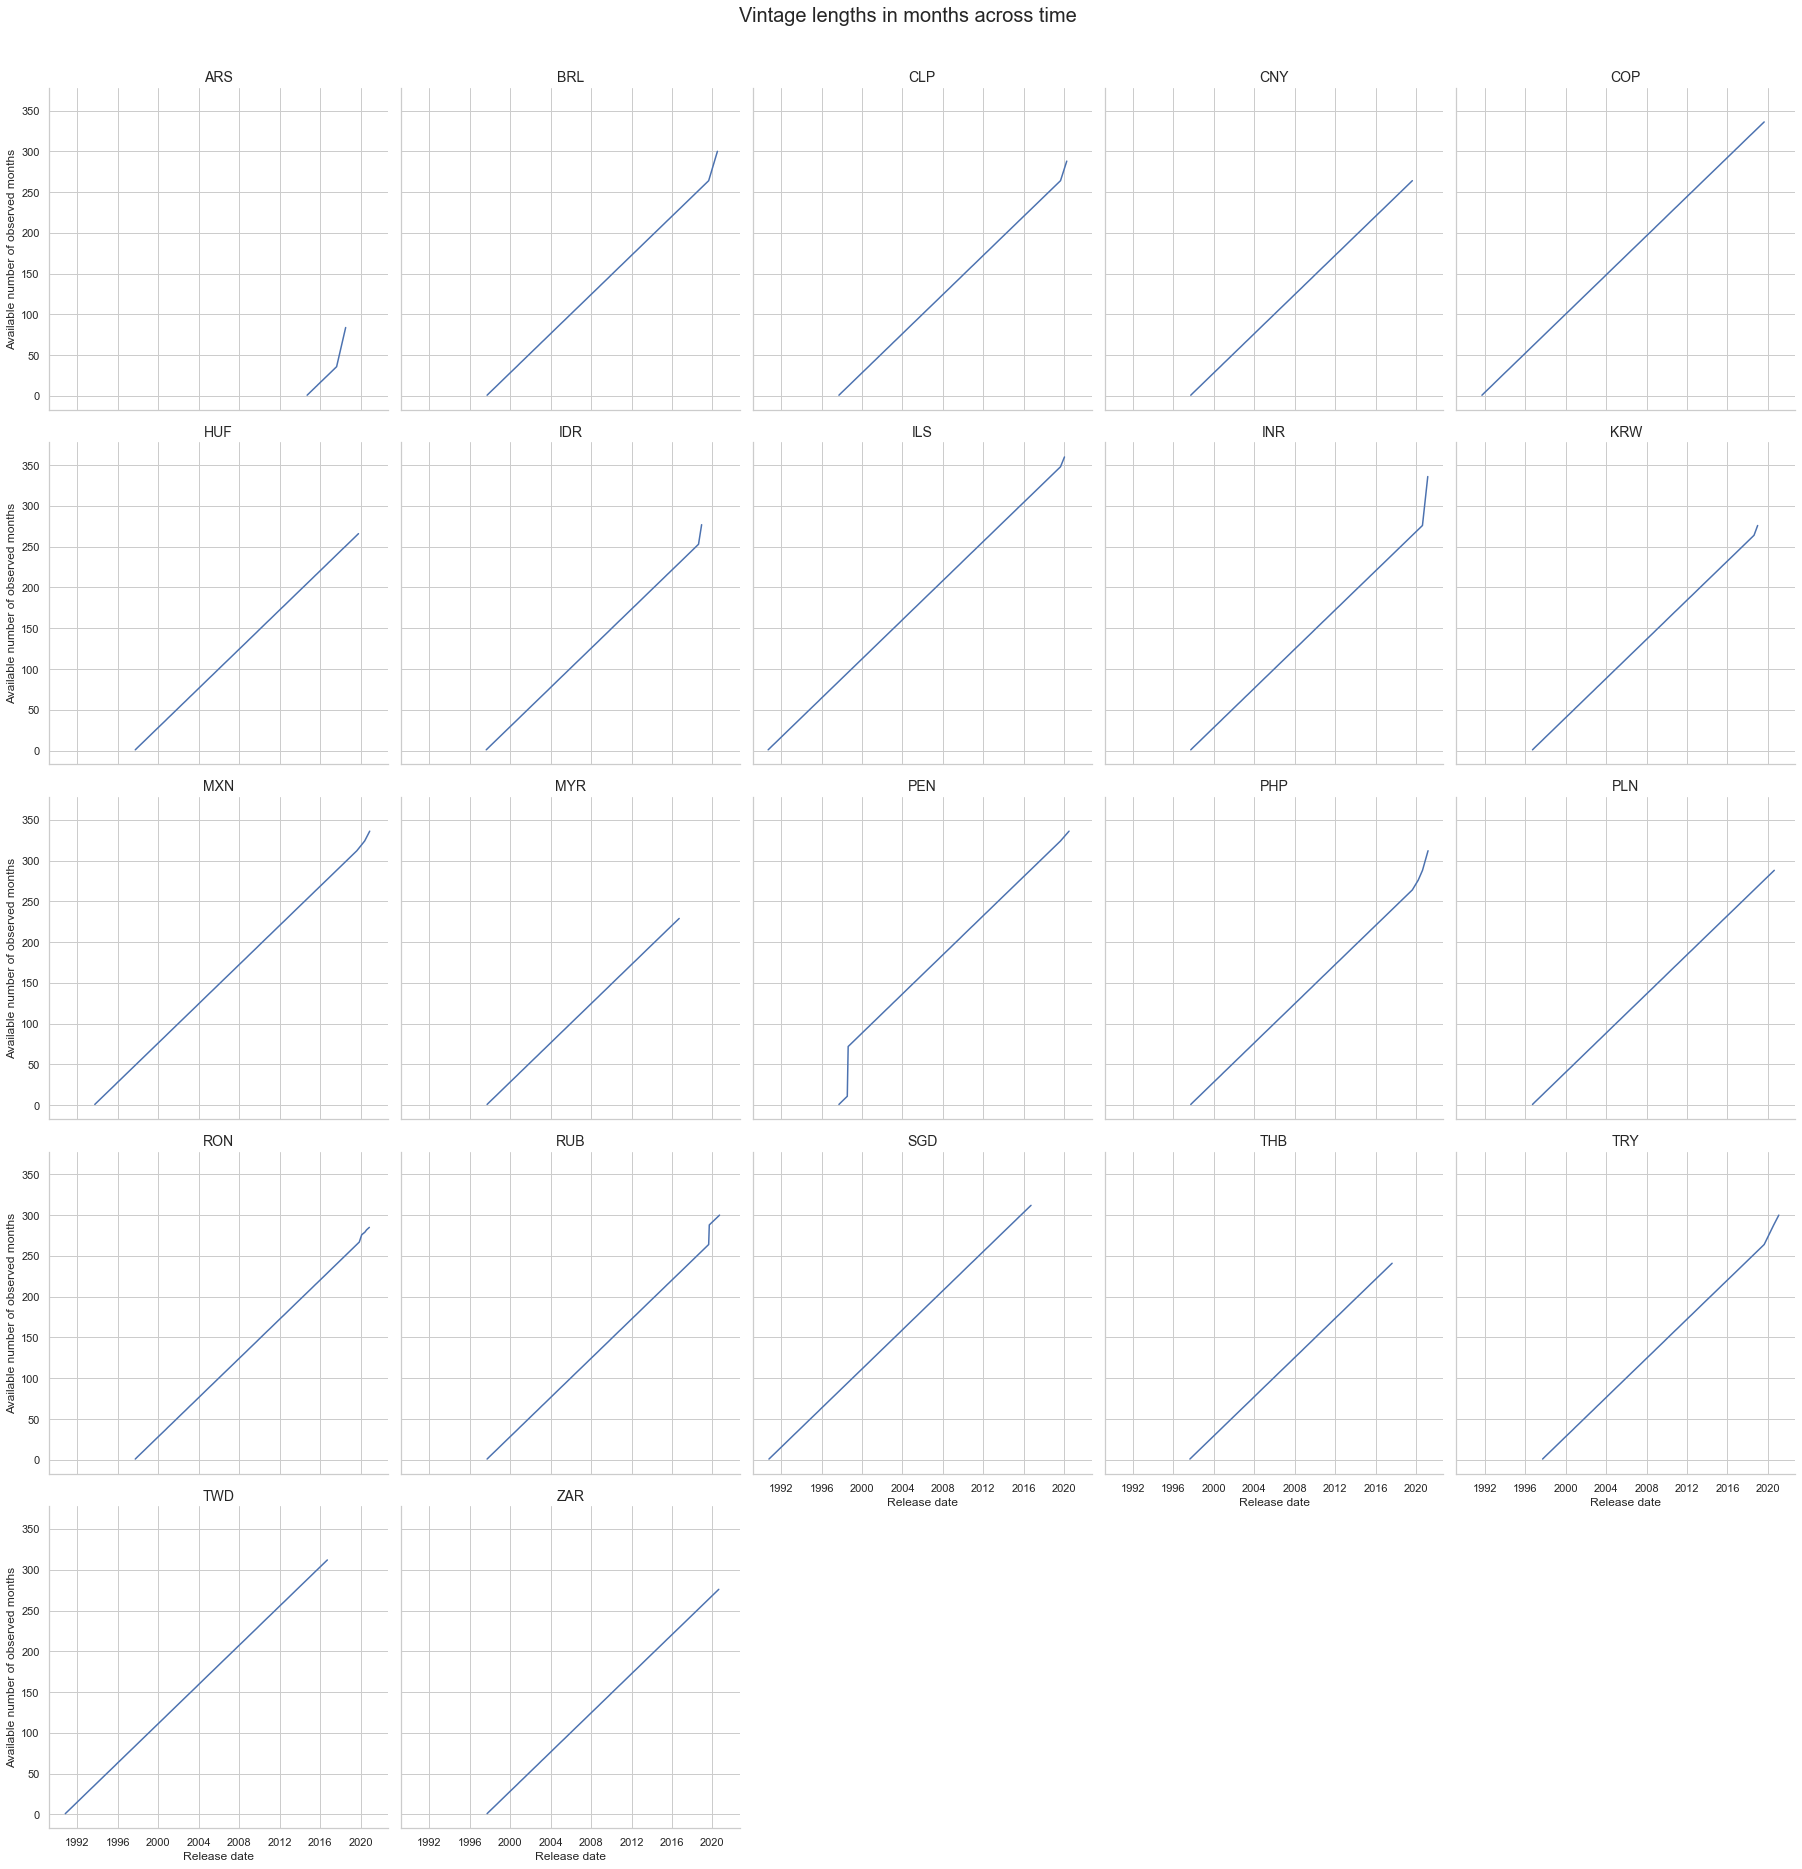

In [12]:
cidx = cids_ifav & set(cids_em)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFTAVG'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

### Vintage lines

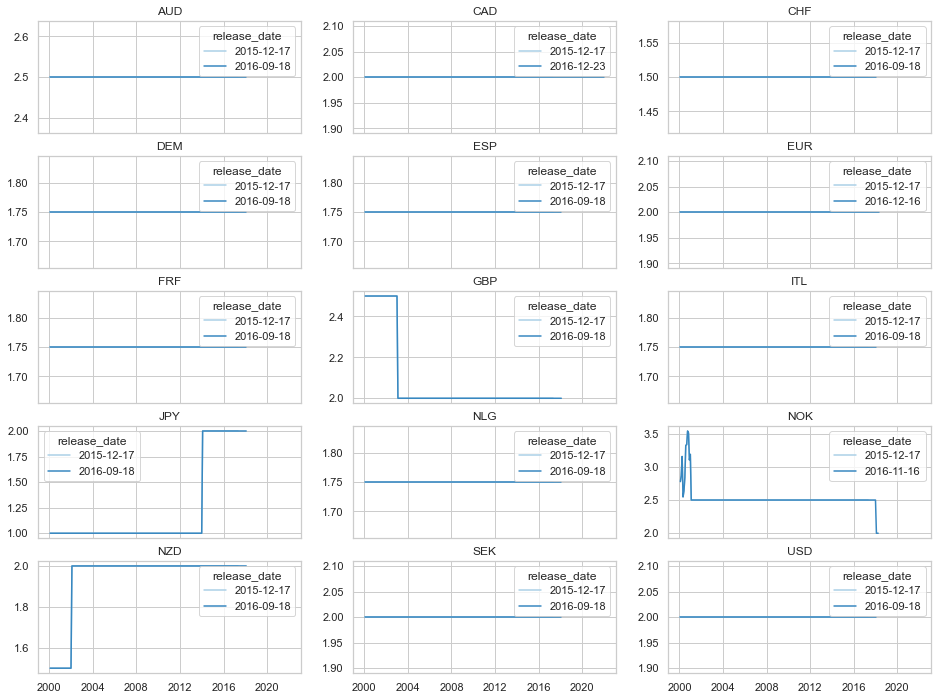

In [13]:
cidx = cids_ifav & set(cids_dm)
pots = ['2016-12-31', '2015-12-31']  # excludes 

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFTAVG'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 12))

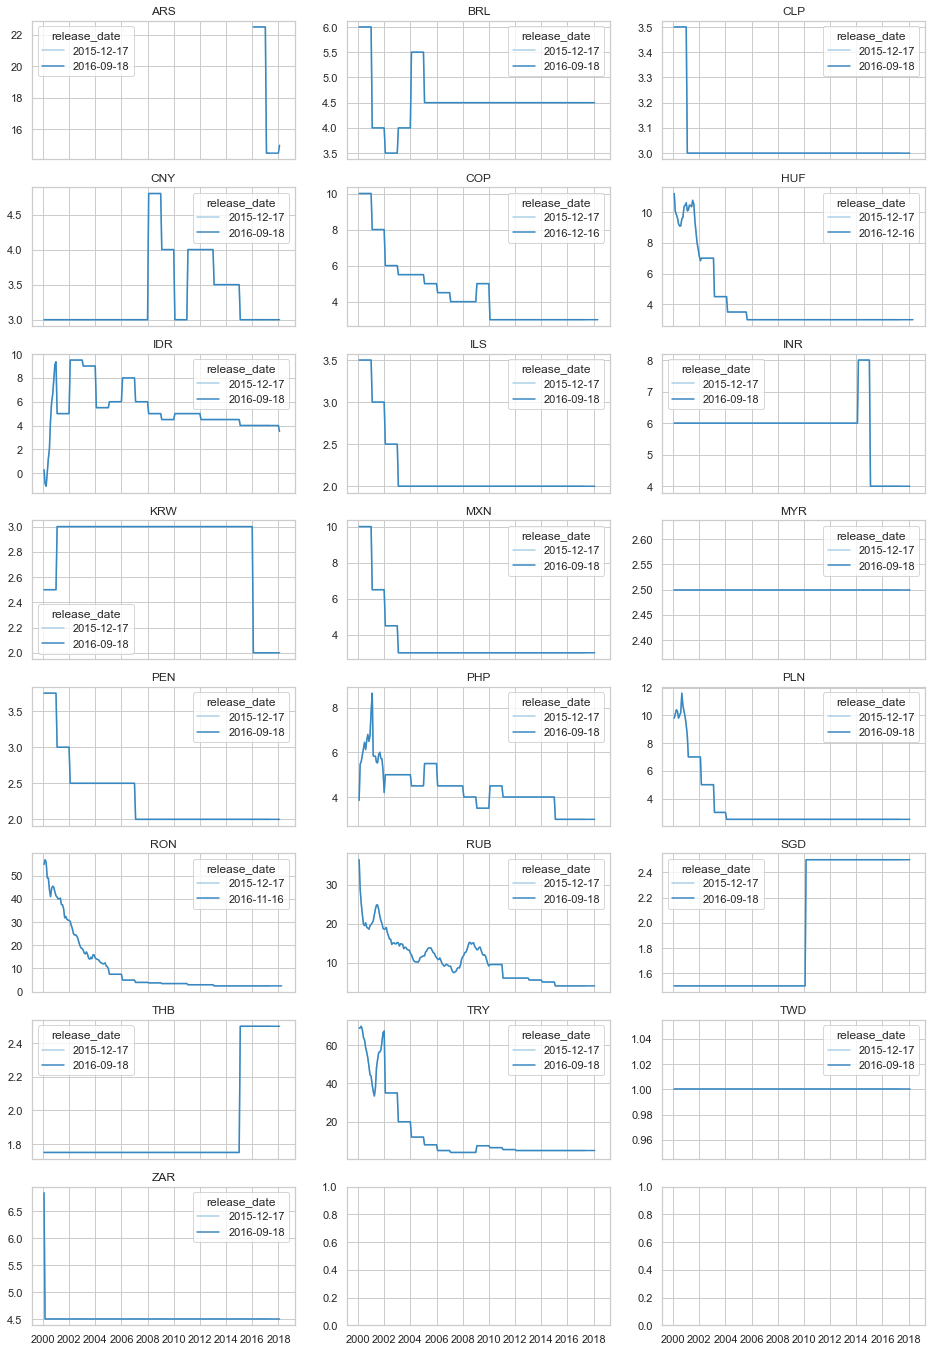

In [14]:
cidx = cids_ifav & set(cids_em)
pots = ['2016-12-31', '2015-12-31']  # excludes '2019-12-31'

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFTAVG'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 24))

## Estimated effective inflation targets

### Vintage availability

In [15]:
cids_ifet = set(dfm.loc[dfm['category_code']=='INFTEFF', 'cross_section'].unique())  # set of cross-sections in downloaded df
print('Cross sections outside the regular global set: ', cids_ifet - set(cids)) 
print('Cross sections missing from regular global set: ', set(cids) - cids_ifet) 

Cross sections outside the regular global set:  set()
Cross sections missing from regular global set:  {'HKD', 'ARS'}


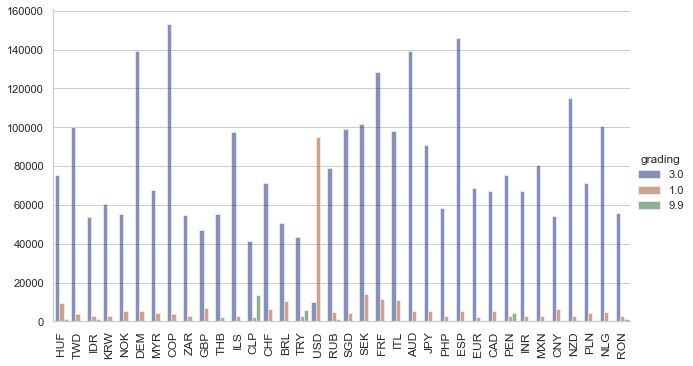

In [16]:
sns.set_theme(style='whitegrid')
fg = sns.catplot(data=dfm[dfm['category_code']=='INFTEFF'], kind='count', hue='grading', order=cids_ifet, 
                 x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
fg.set_xticklabels(rotation=90, size=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

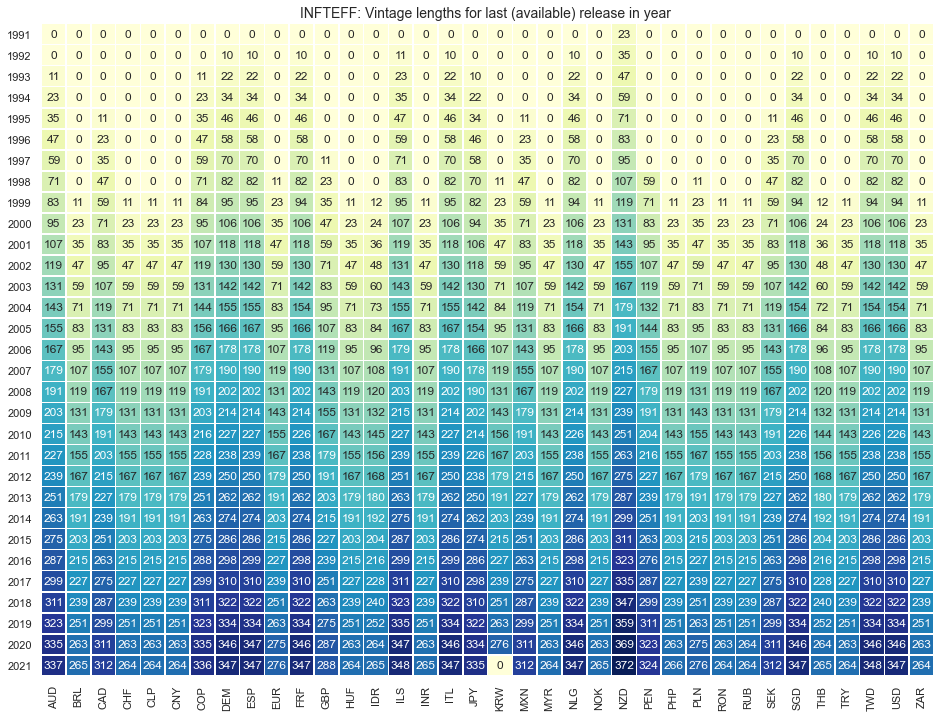

In [17]:
countmap('INFTEFF', 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

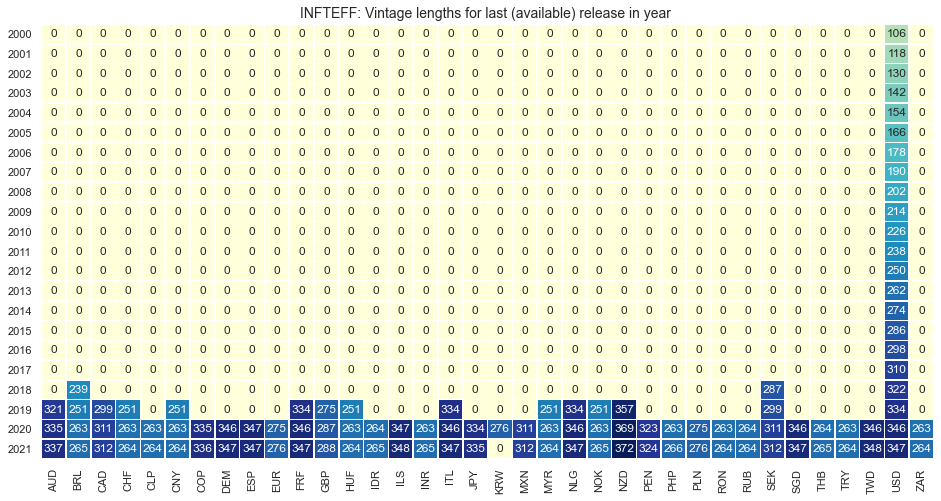

In [18]:
countmap('INFTEFF', 1990, (16, 8), trueVin=True)
plt.show

### Vintage consistency

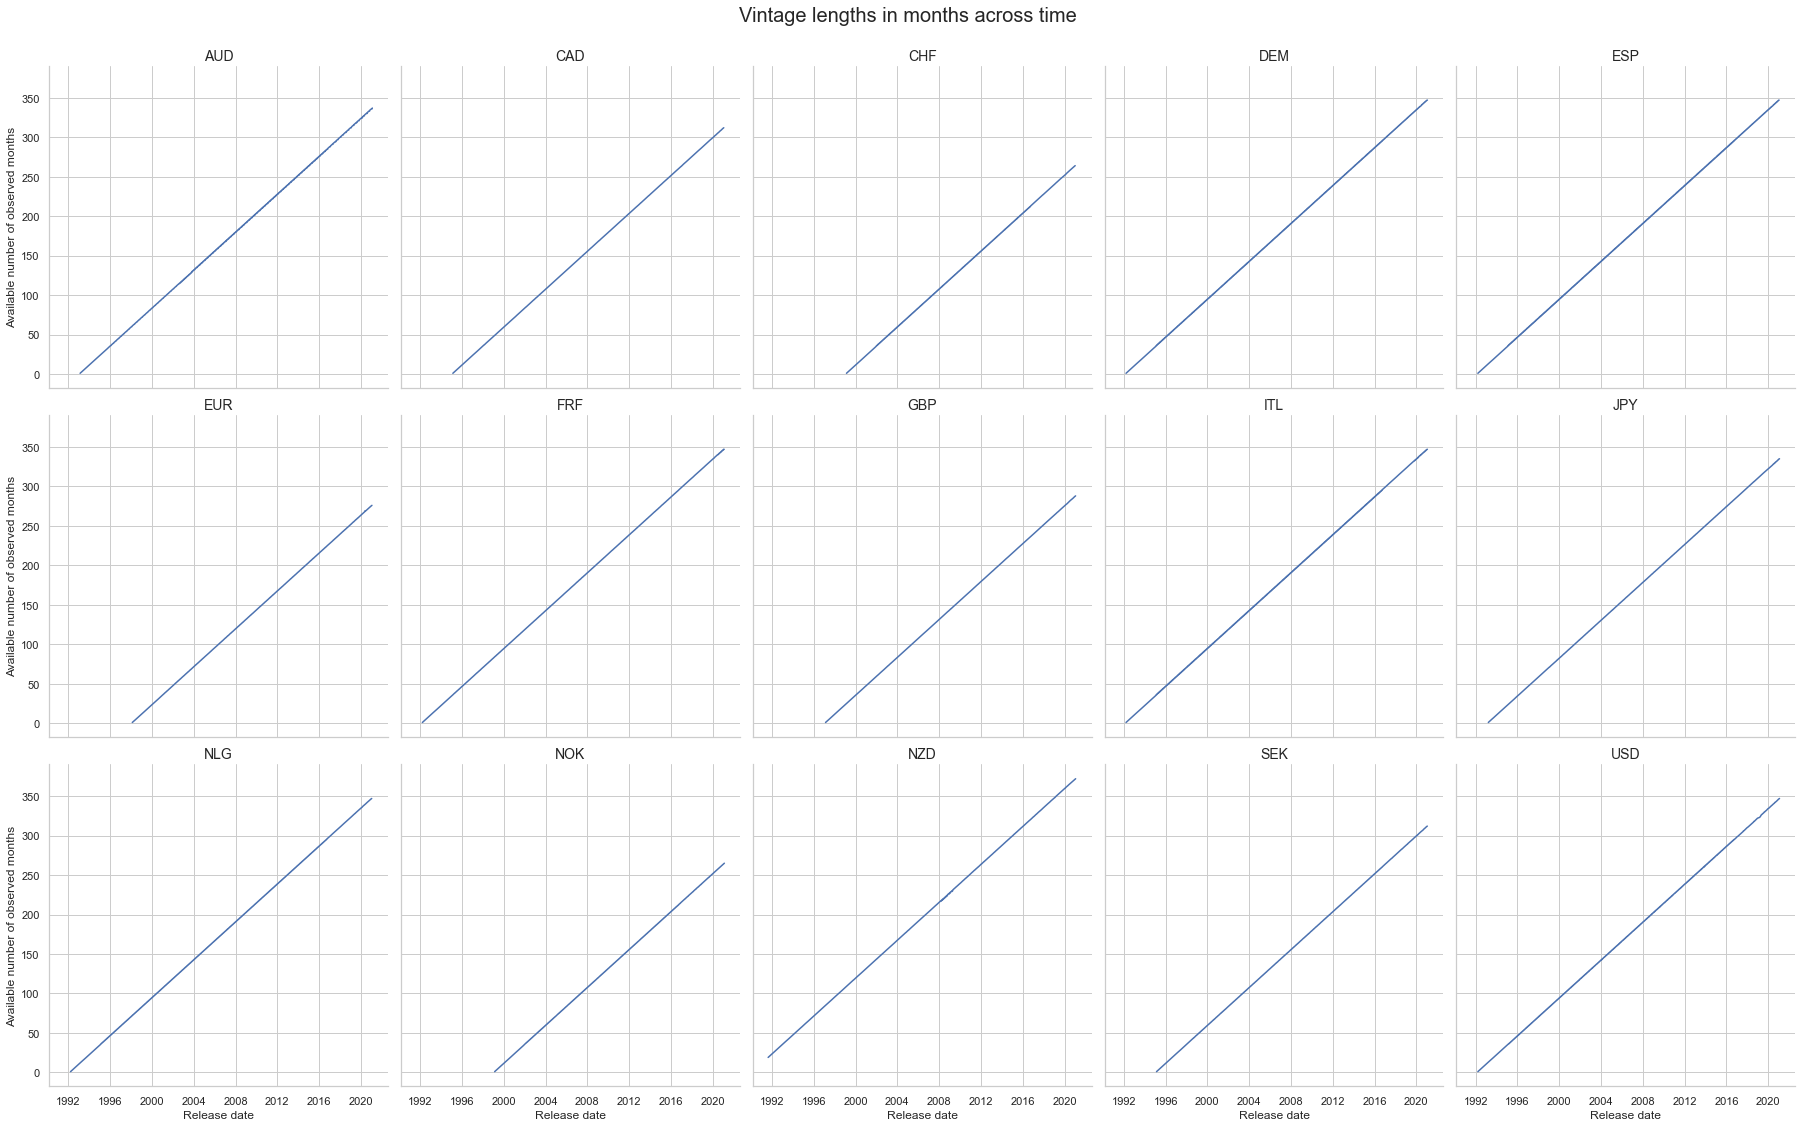

In [25]:
cidx = cids_ifet & set(cids_dm)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFTEFF'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

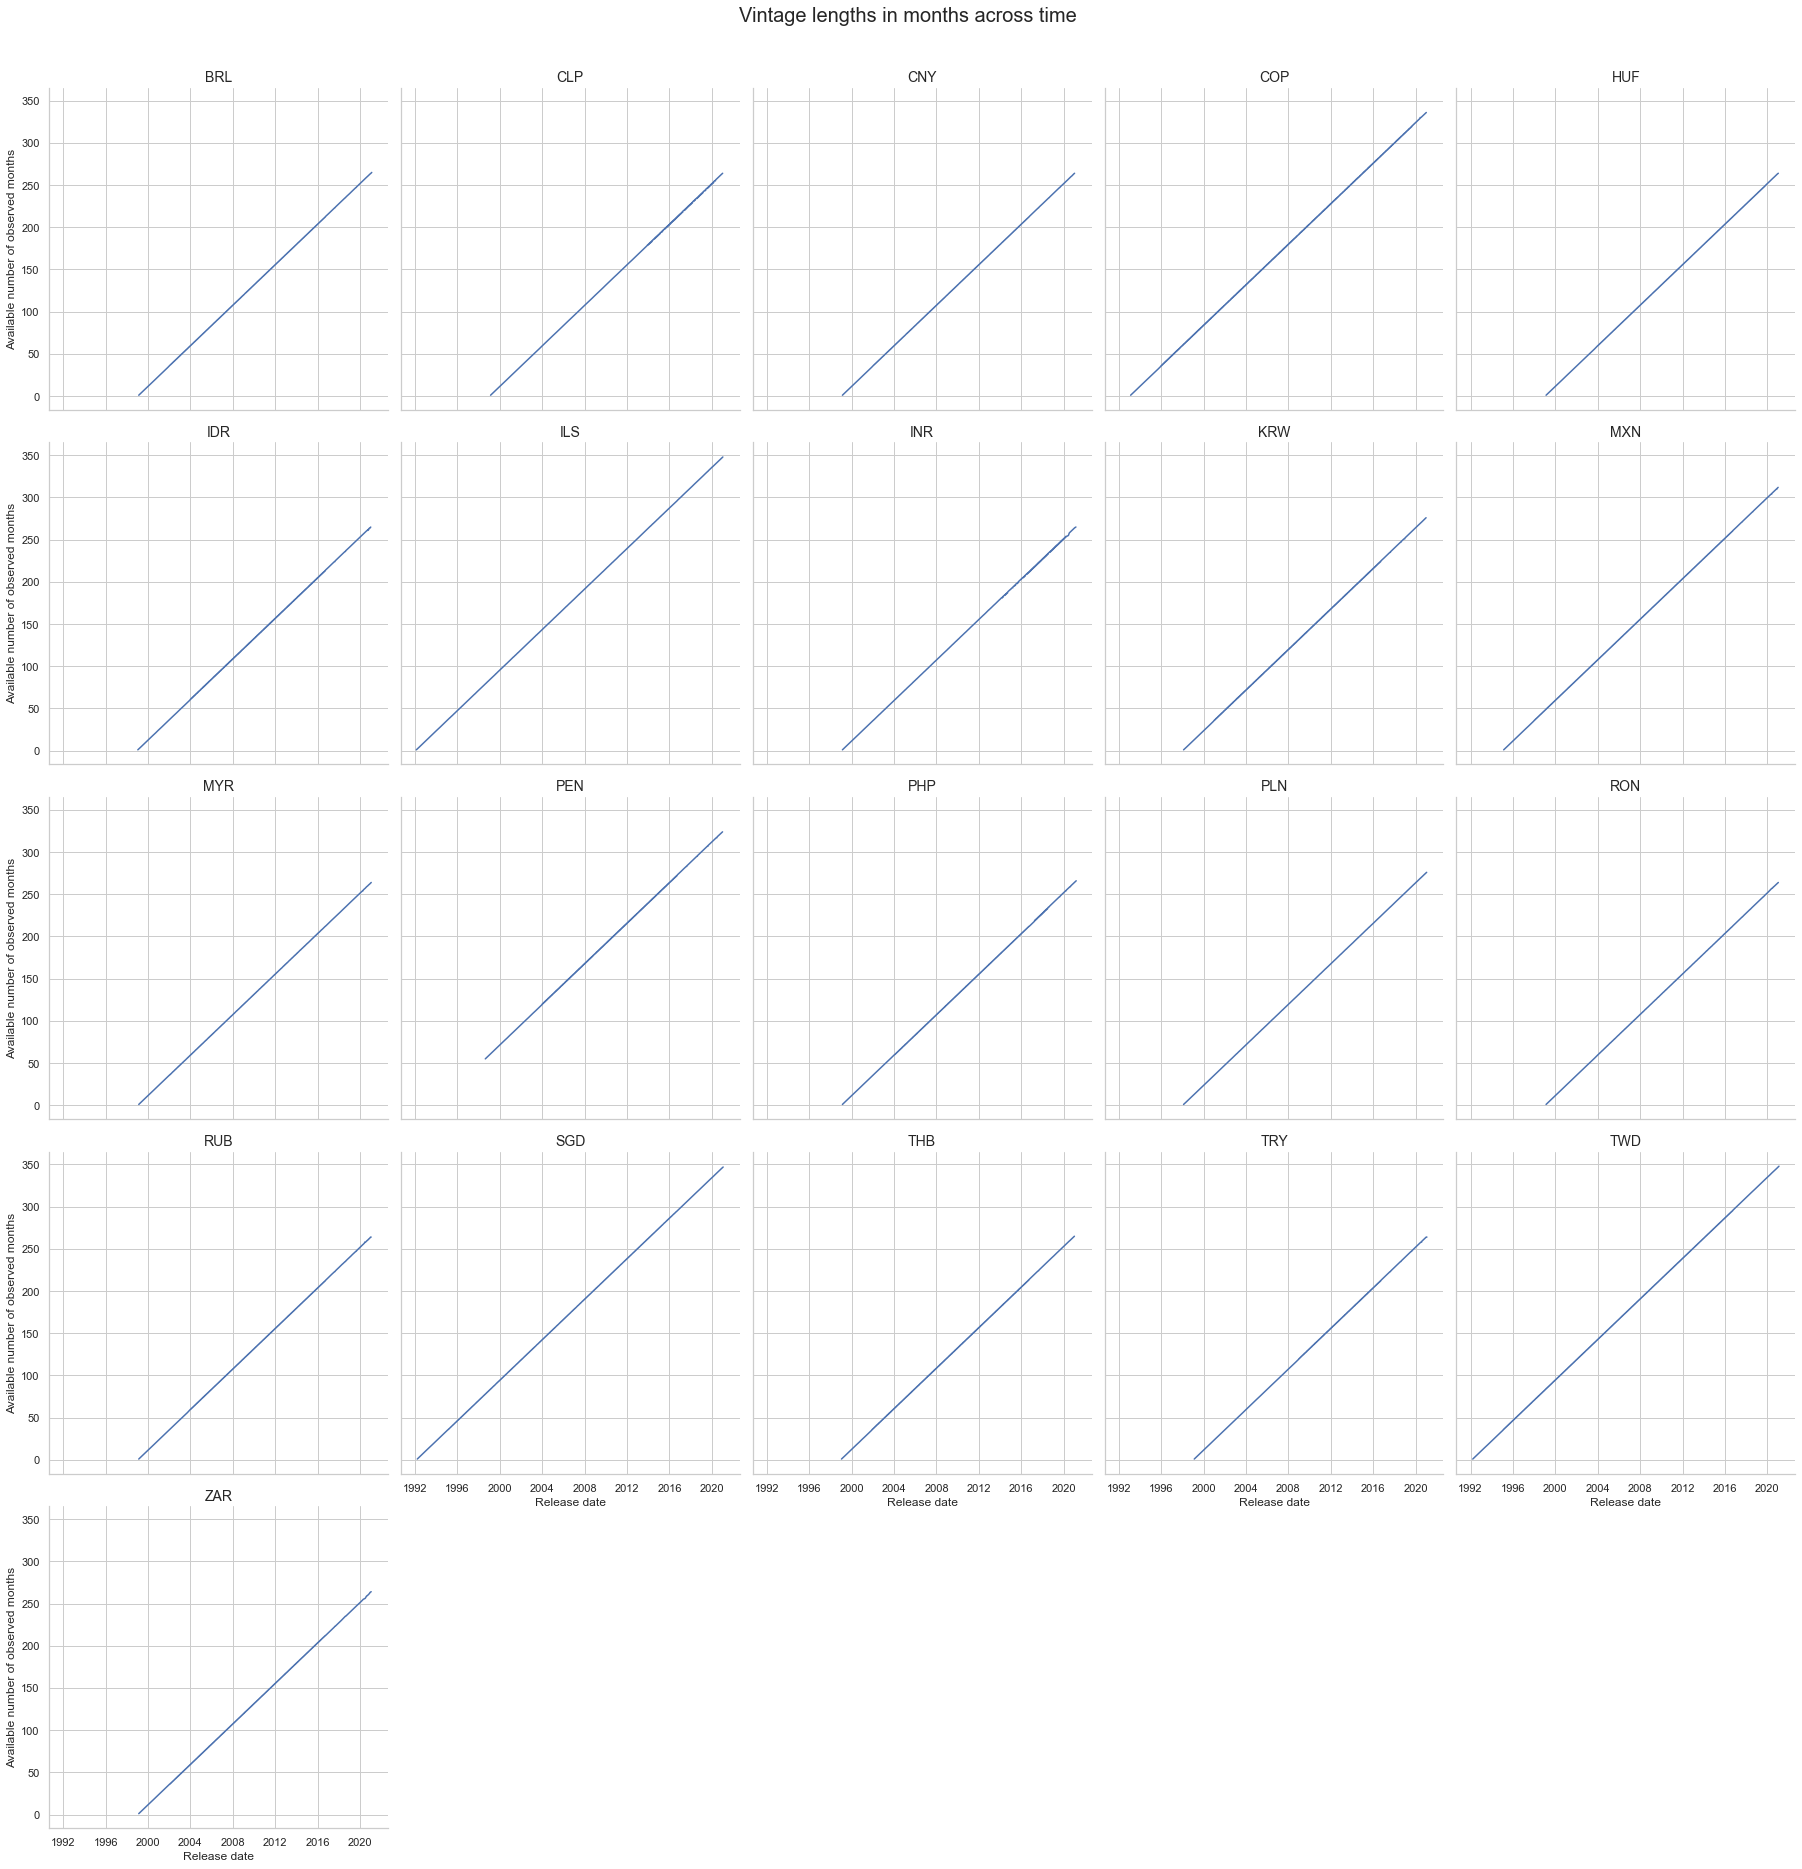

In [26]:
cidx = cids_ifet & set(cids_em)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFTEFF'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

### Vintage lines

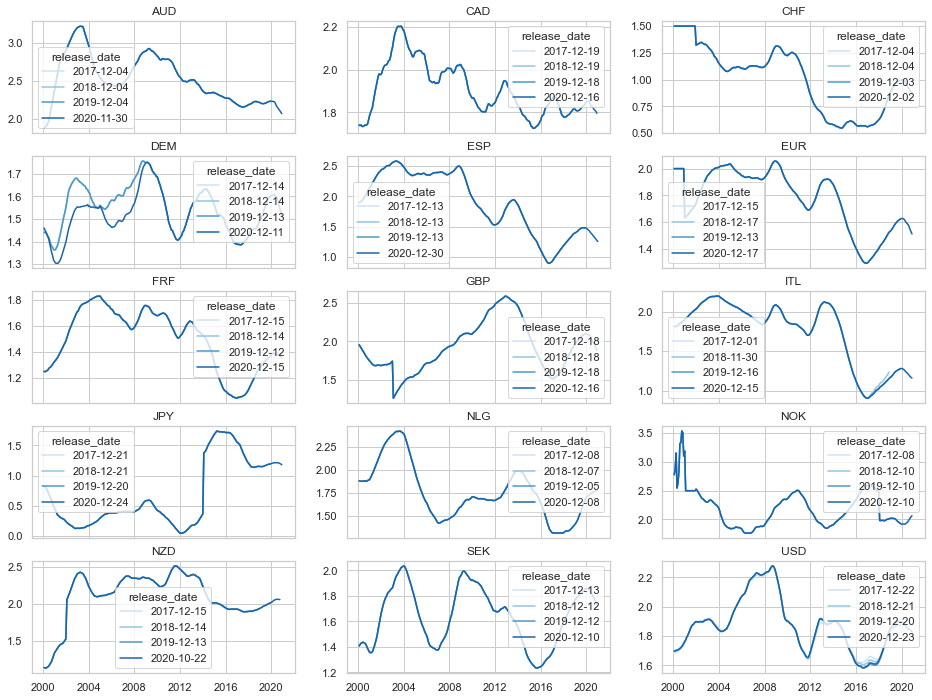

In [30]:
cidx = cids_ifet & set(cids_dm)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFTEFF'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 12))

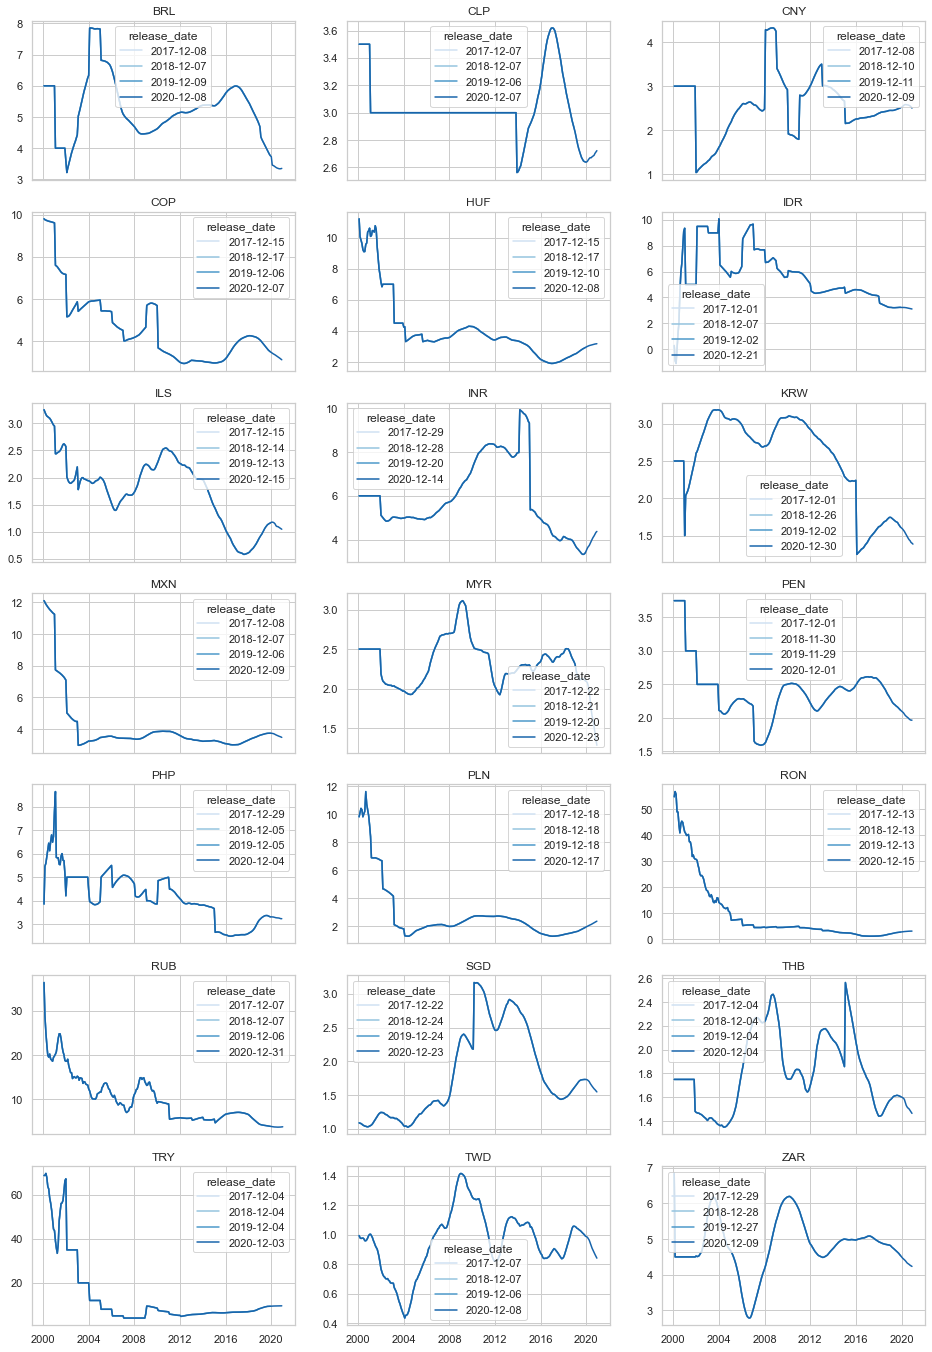

In [31]:
cidx = cids_ifet & set(cids_em)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFTEFF'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 24))

## Estimated 1-year ahead inflation expectation

### Vintage availability

In [33]:
cids_ife1 = set(dfm.loc[dfm['category_code']=='INFE1Y', 'cross_section'].unique())  # set of cross-sections in downloaded df
print('Cross sections outside the regular global set: ', cids_ife1 - set(cids)) 
print('Cross sections missing from regular global set: ', set(cids) - cids_ife1) 

Cross sections outside the regular global set:  set()
Cross sections missing from regular global set:  {'HKD', 'ARS'}


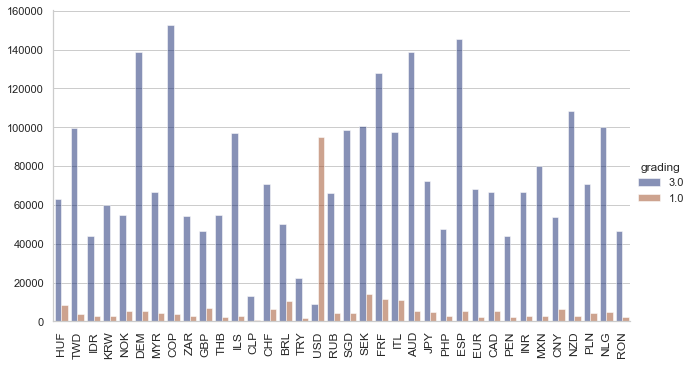

In [34]:
sns.set_theme(style='whitegrid')
fg = sns.catplot(data=dfm[dfm['category_code']=='INFE1Y'], kind='count', hue='grading', order=cids_ife1, 
                 x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
fg.set_xticklabels(rotation=90, size=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

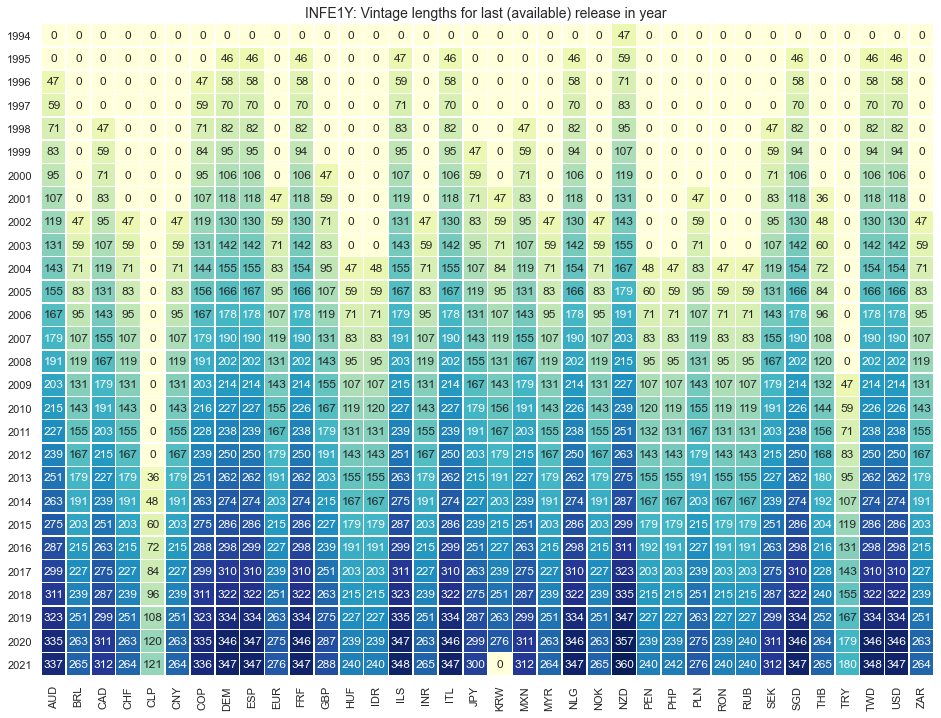

In [35]:
countmap('INFE1Y', 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

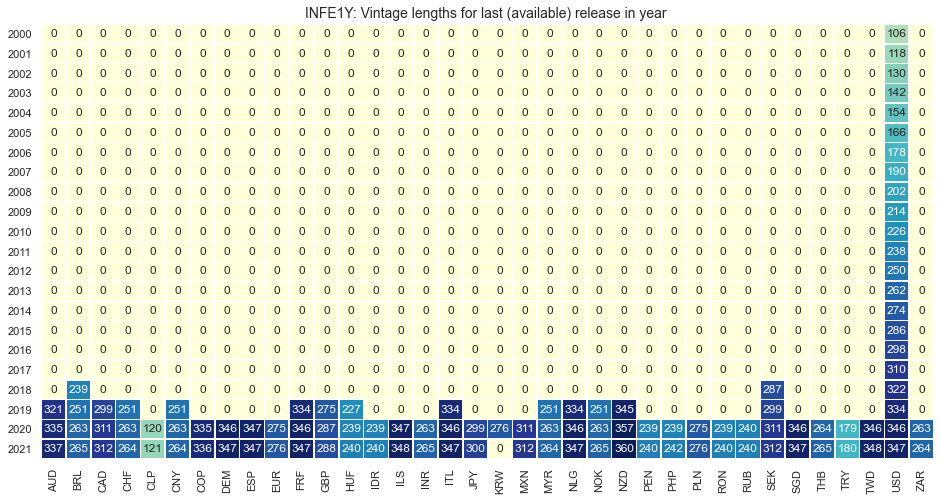

In [36]:
countmap('INFE1Y', 1990, (16, 8), trueVin=True)
plt.show

### Vintage consistency

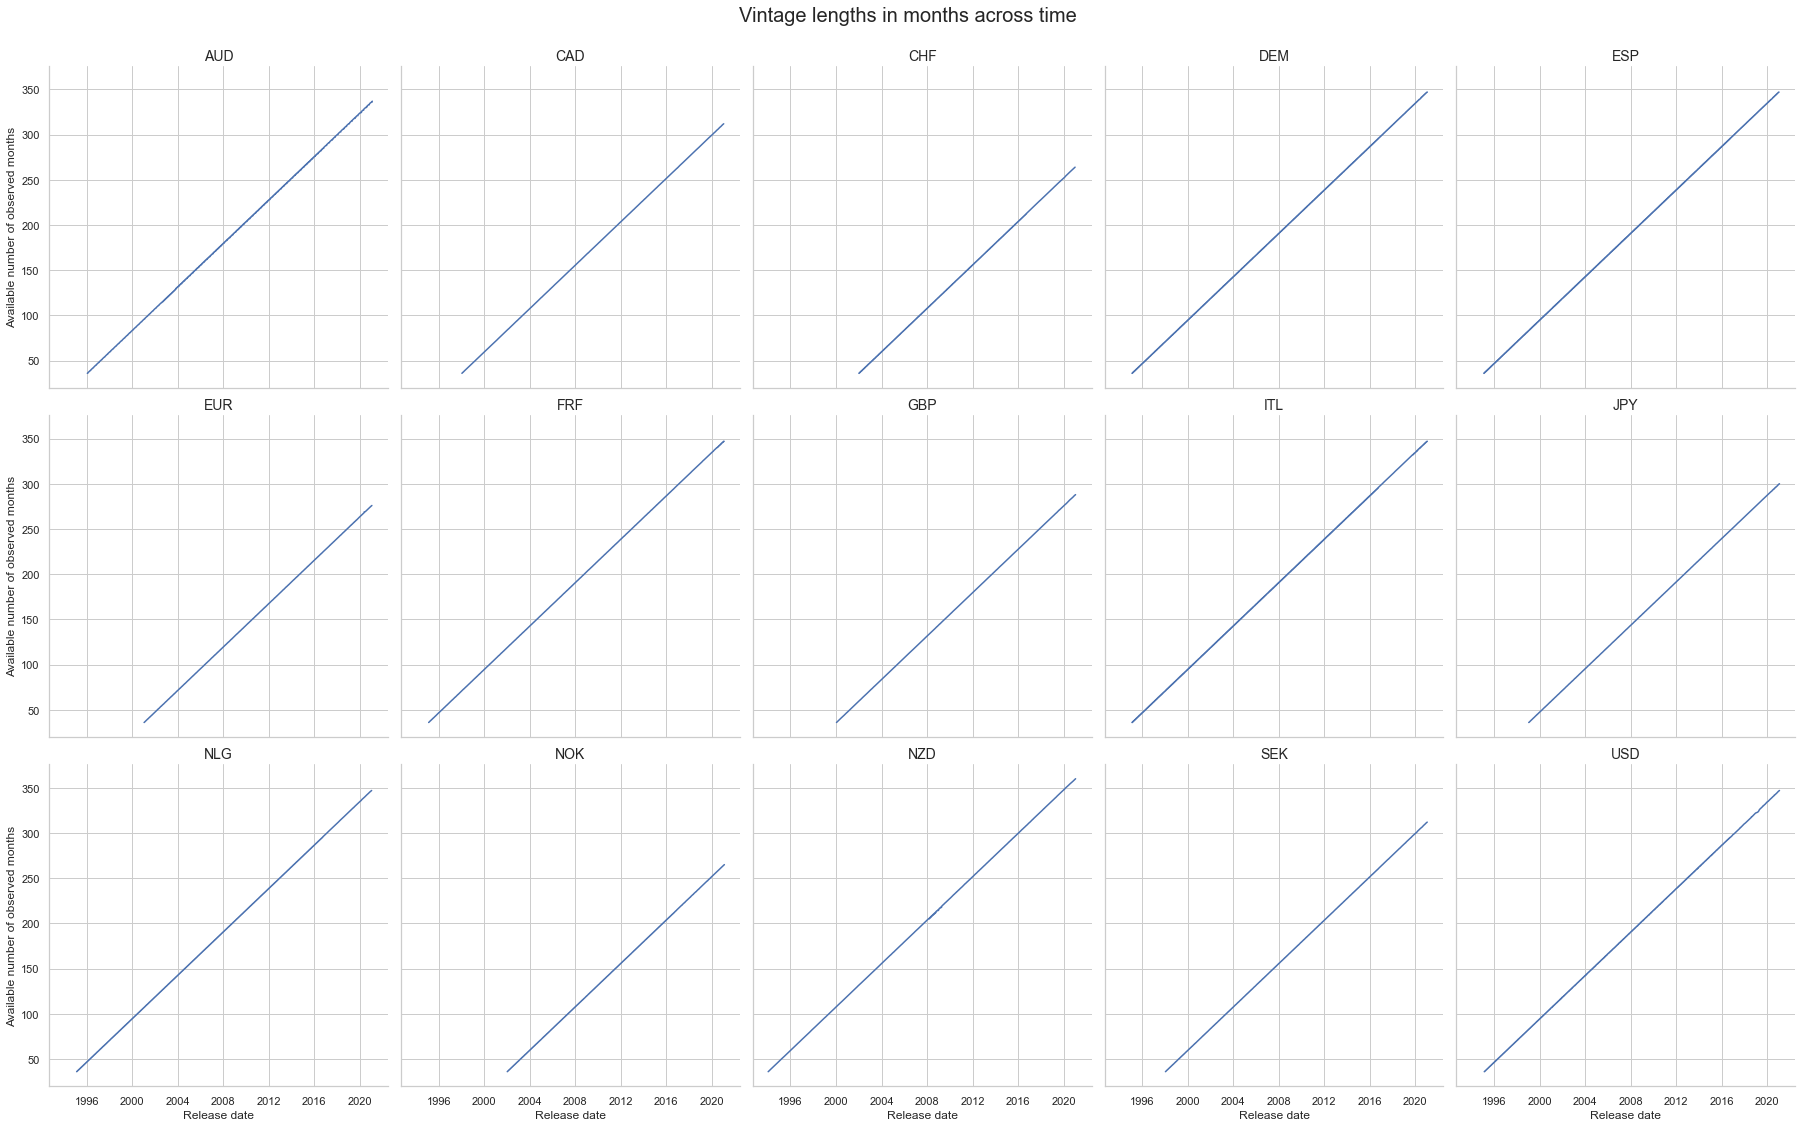

In [37]:
cidx = cids_ife1 & set(cids_dm)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE1Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

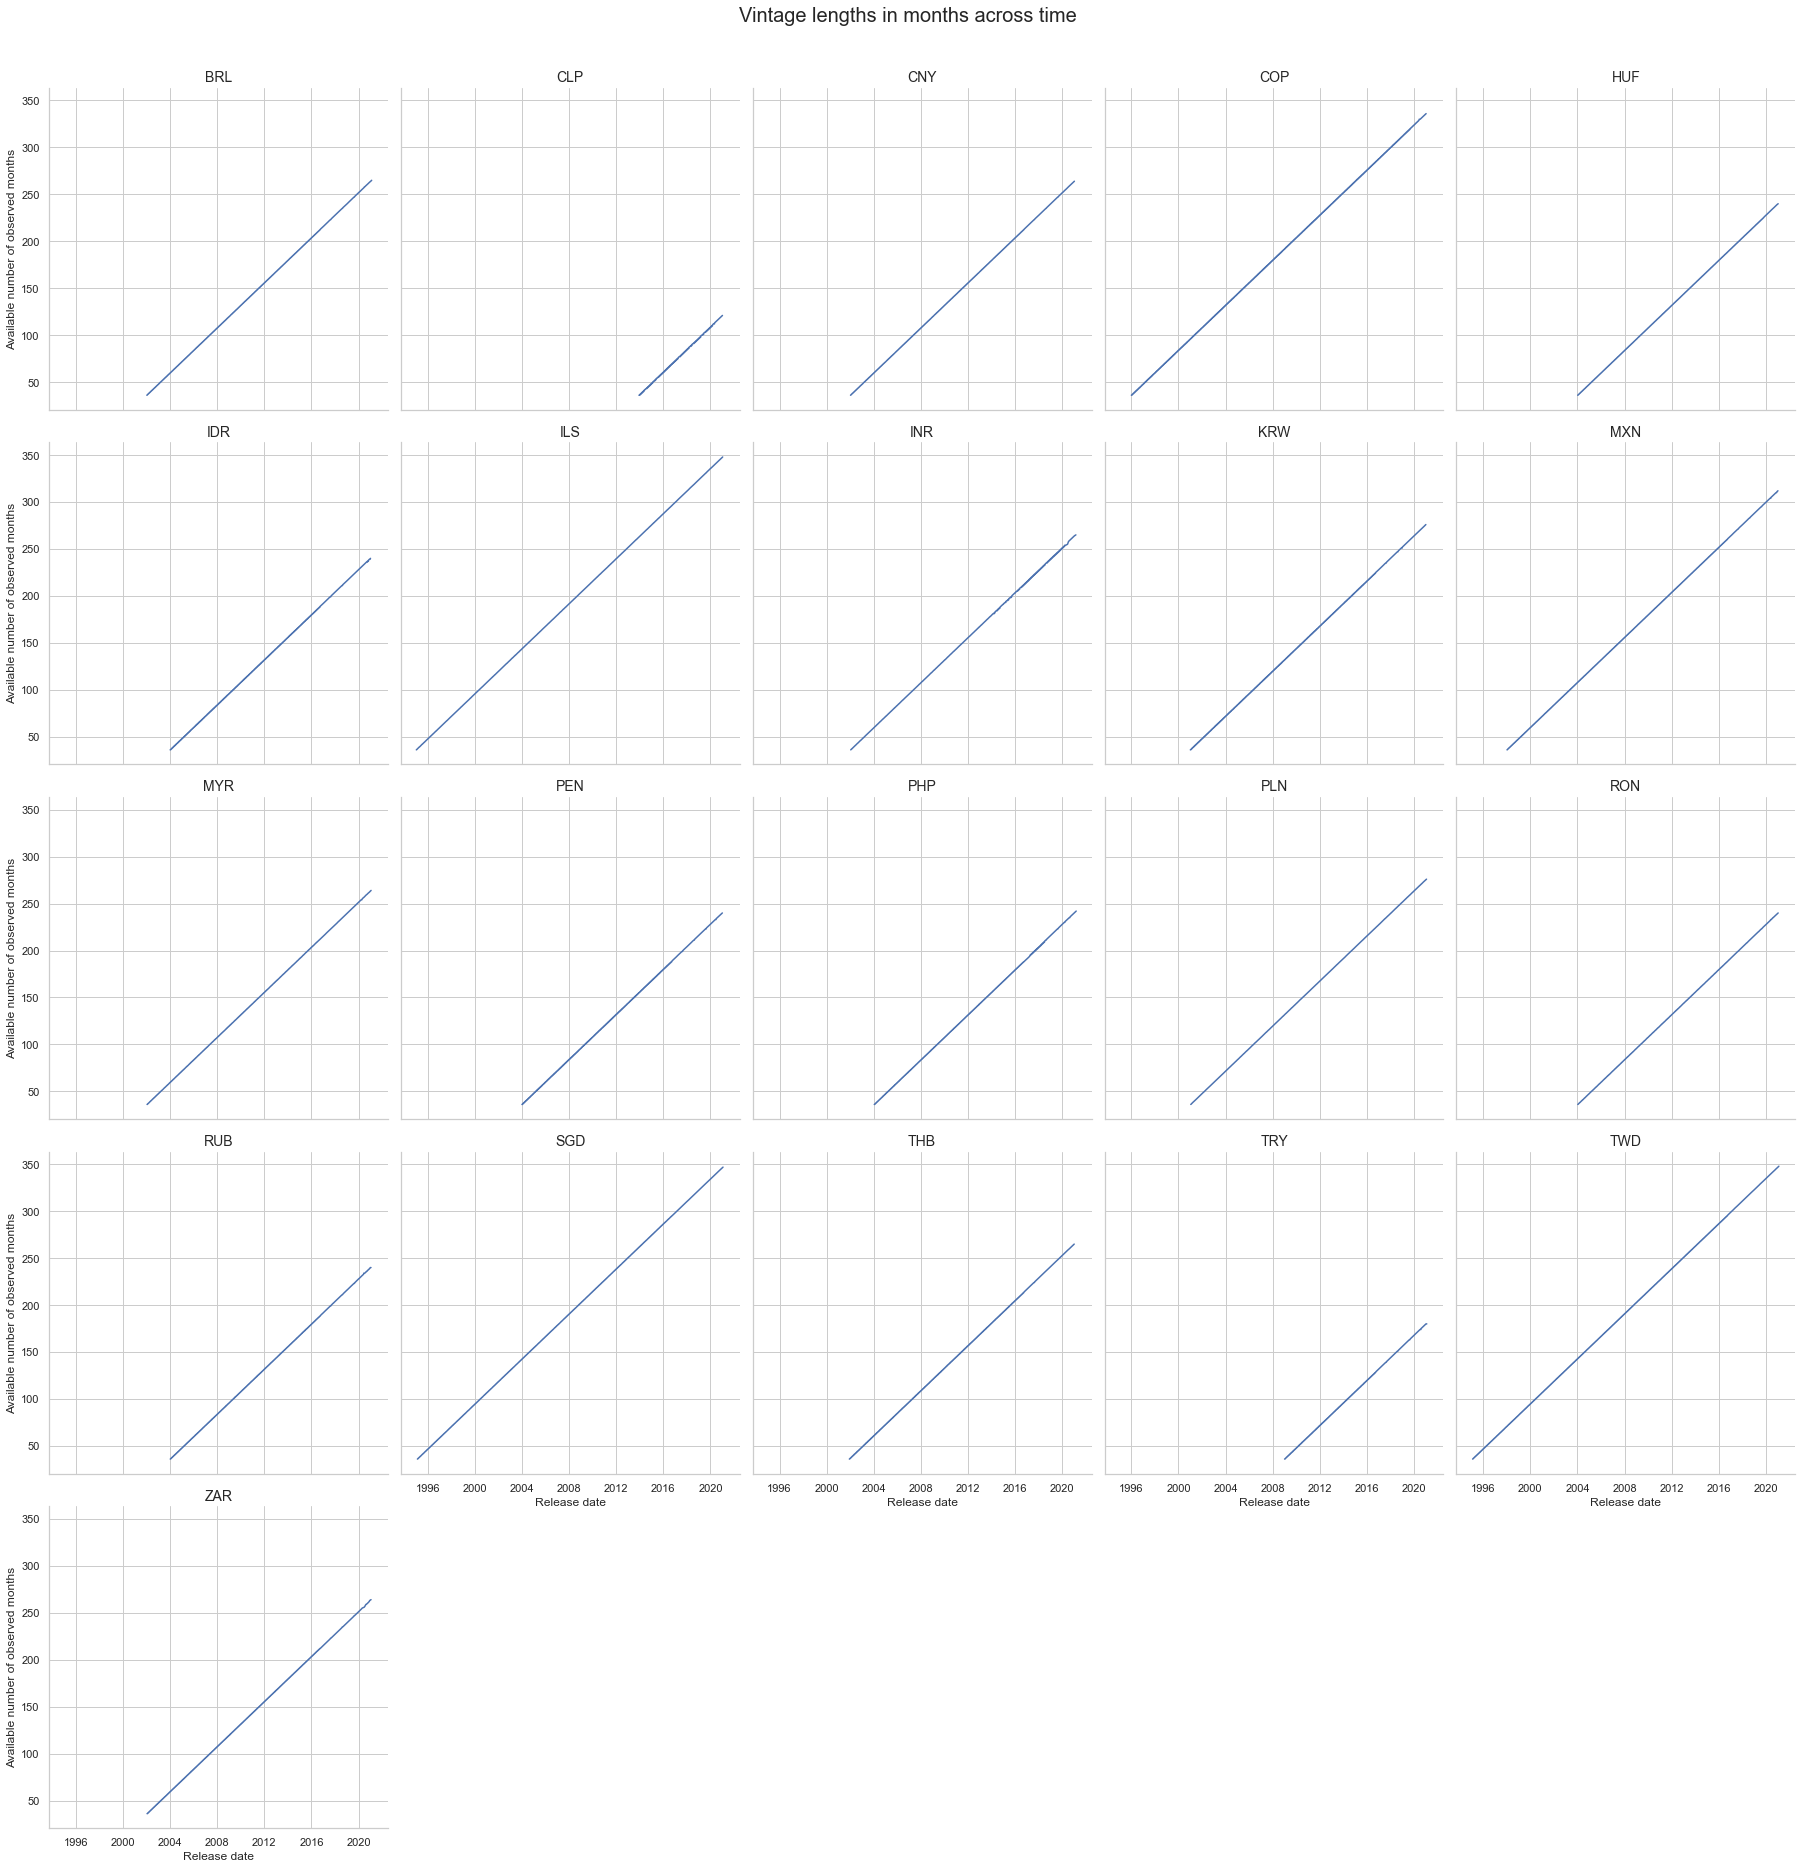

In [38]:
cidx = cids_ife1 & set(cids_em)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE1Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

### Vintage lines

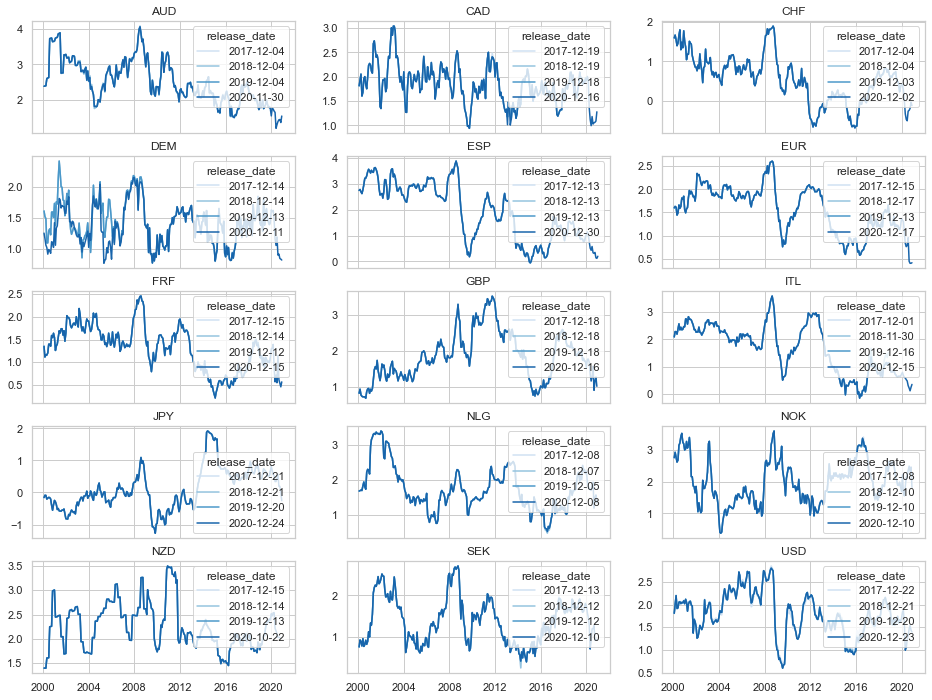

In [39]:
cidx = cids_ife1 & set(cids_dm)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE1Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 12))

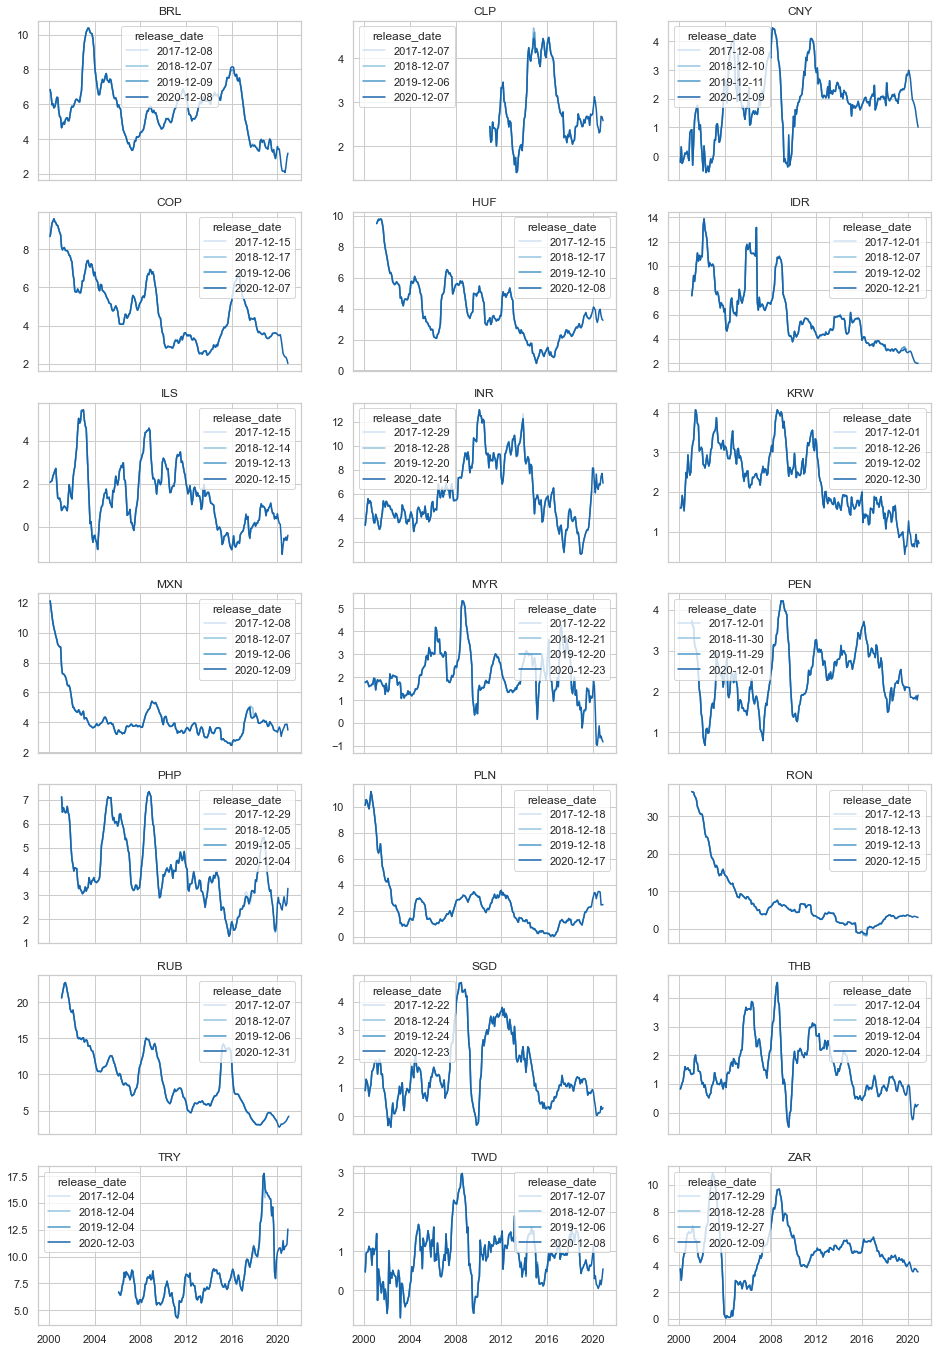

In [40]:
cidx = cids_ife1 & set(cids_em)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE1Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 24))

## Estimated 2-year ahead inflation expectation

### Vintage availability

In [41]:
cids_ife2 = set(dfm.loc[dfm['category_code']=='INFE2Y', 'cross_section'].unique())  # set of cross-sections in downloaded df
print('Cross sections outside the regular global set: ', cids_ife2 - set(cids)) 
print('Cross sections missing from regular global set: ', set(cids) - cids_ife2) 

Cross sections outside the regular global set:  set()
Cross sections missing from regular global set:  {'HKD', 'ARS'}


<function matplotlib.pyplot.show(*args, **kw)>

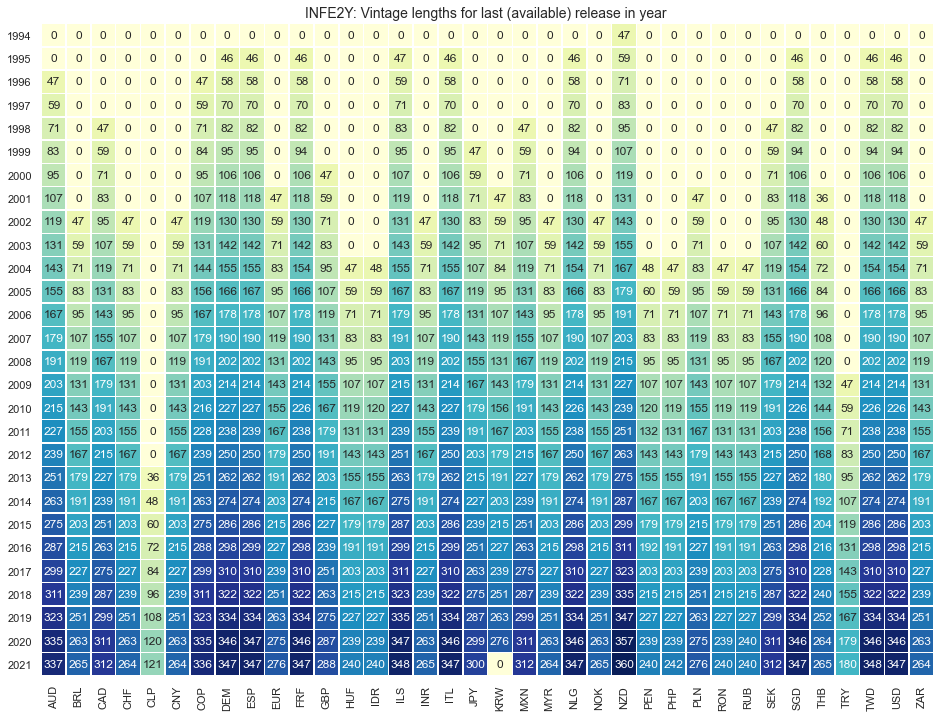

In [42]:
countmap('INFE2Y', 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

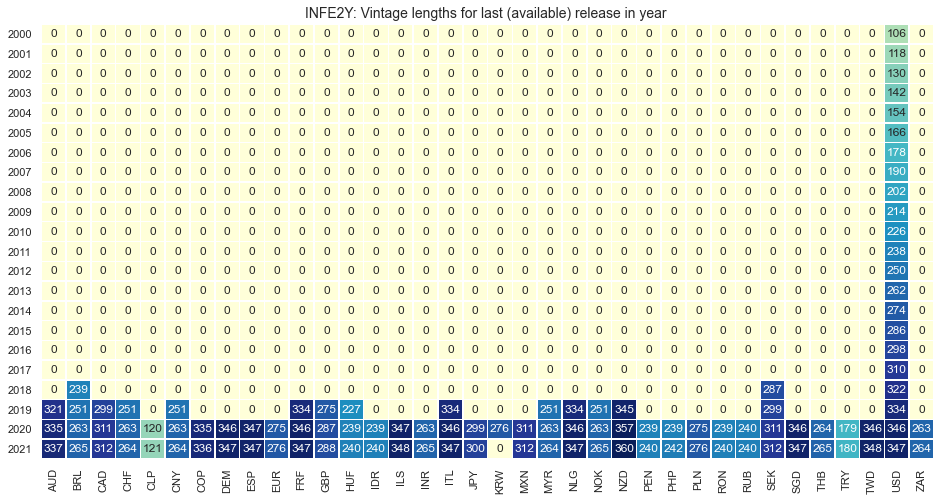

In [43]:
countmap('INFE2Y', 1990, (16, 8), trueVin=True)
plt.show

### Vintage consistency

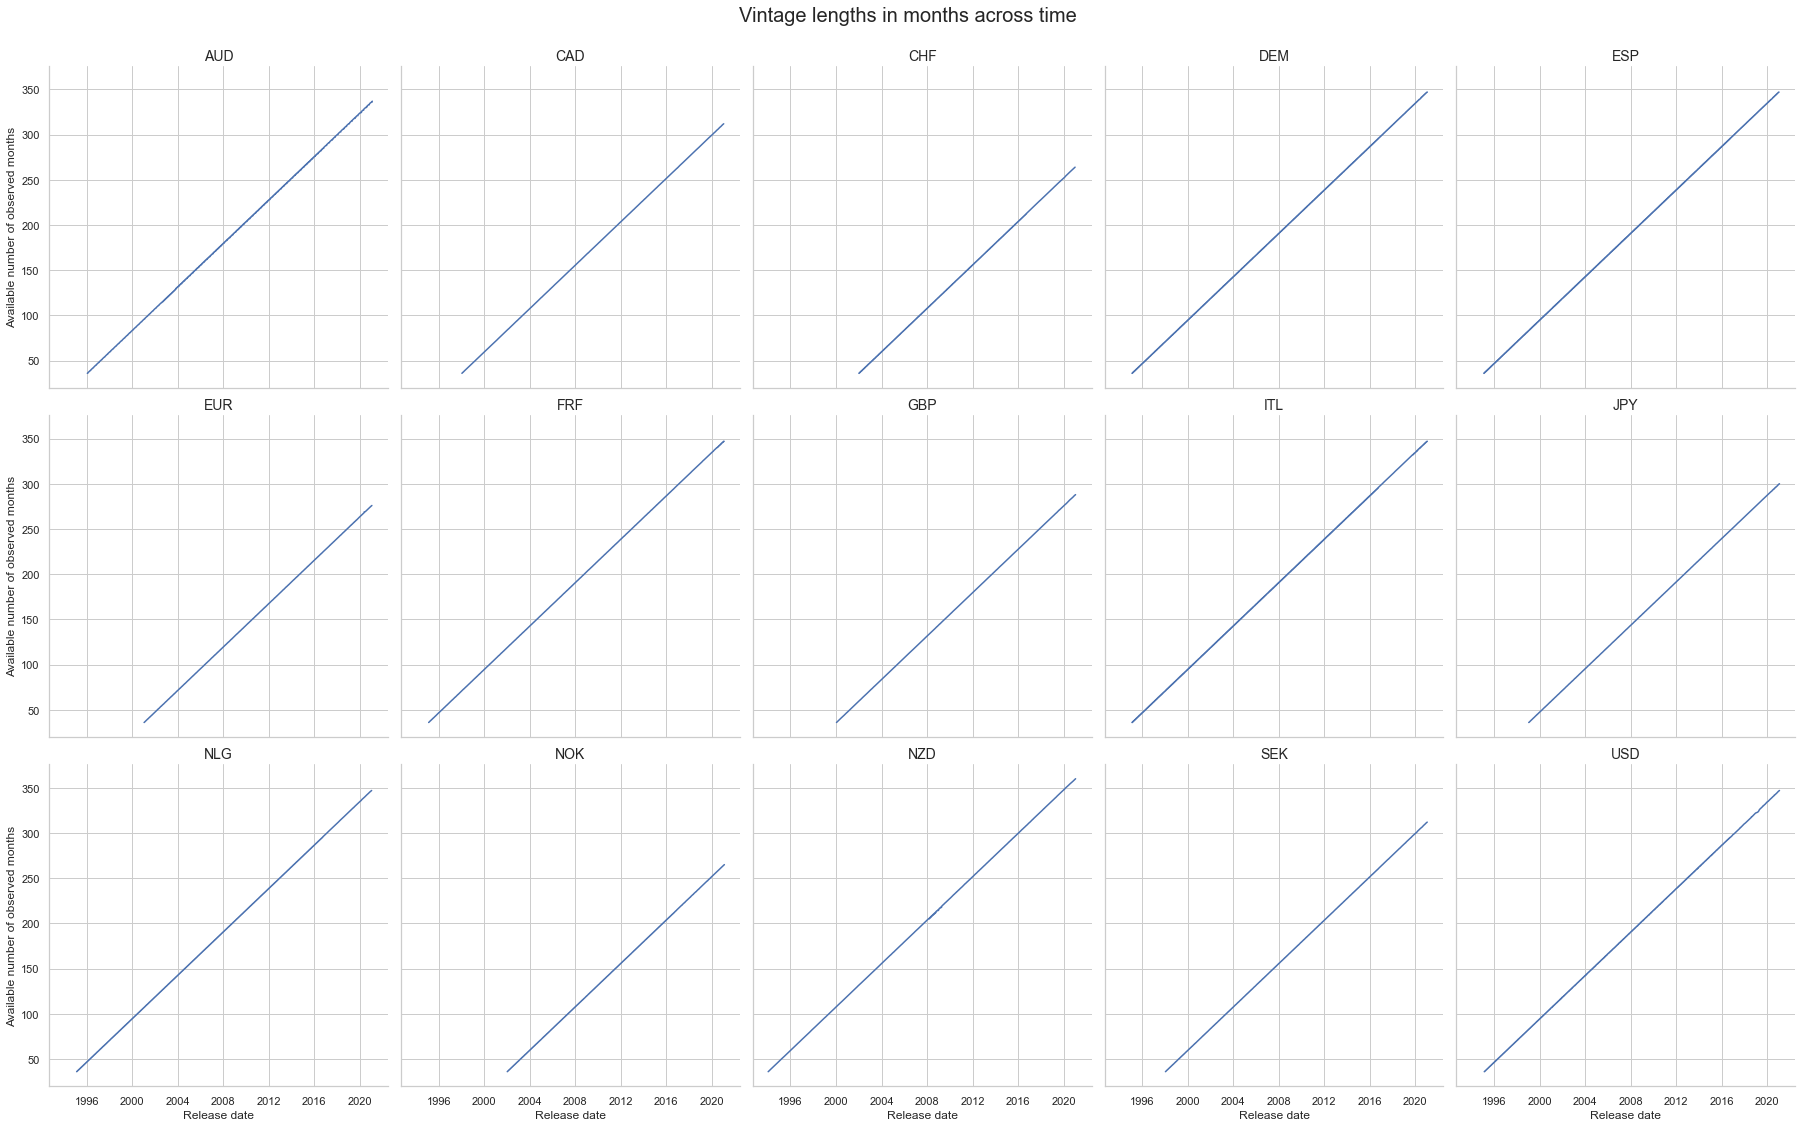

In [44]:
cidx = cids_ife2 & set(cids_dm)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE2Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

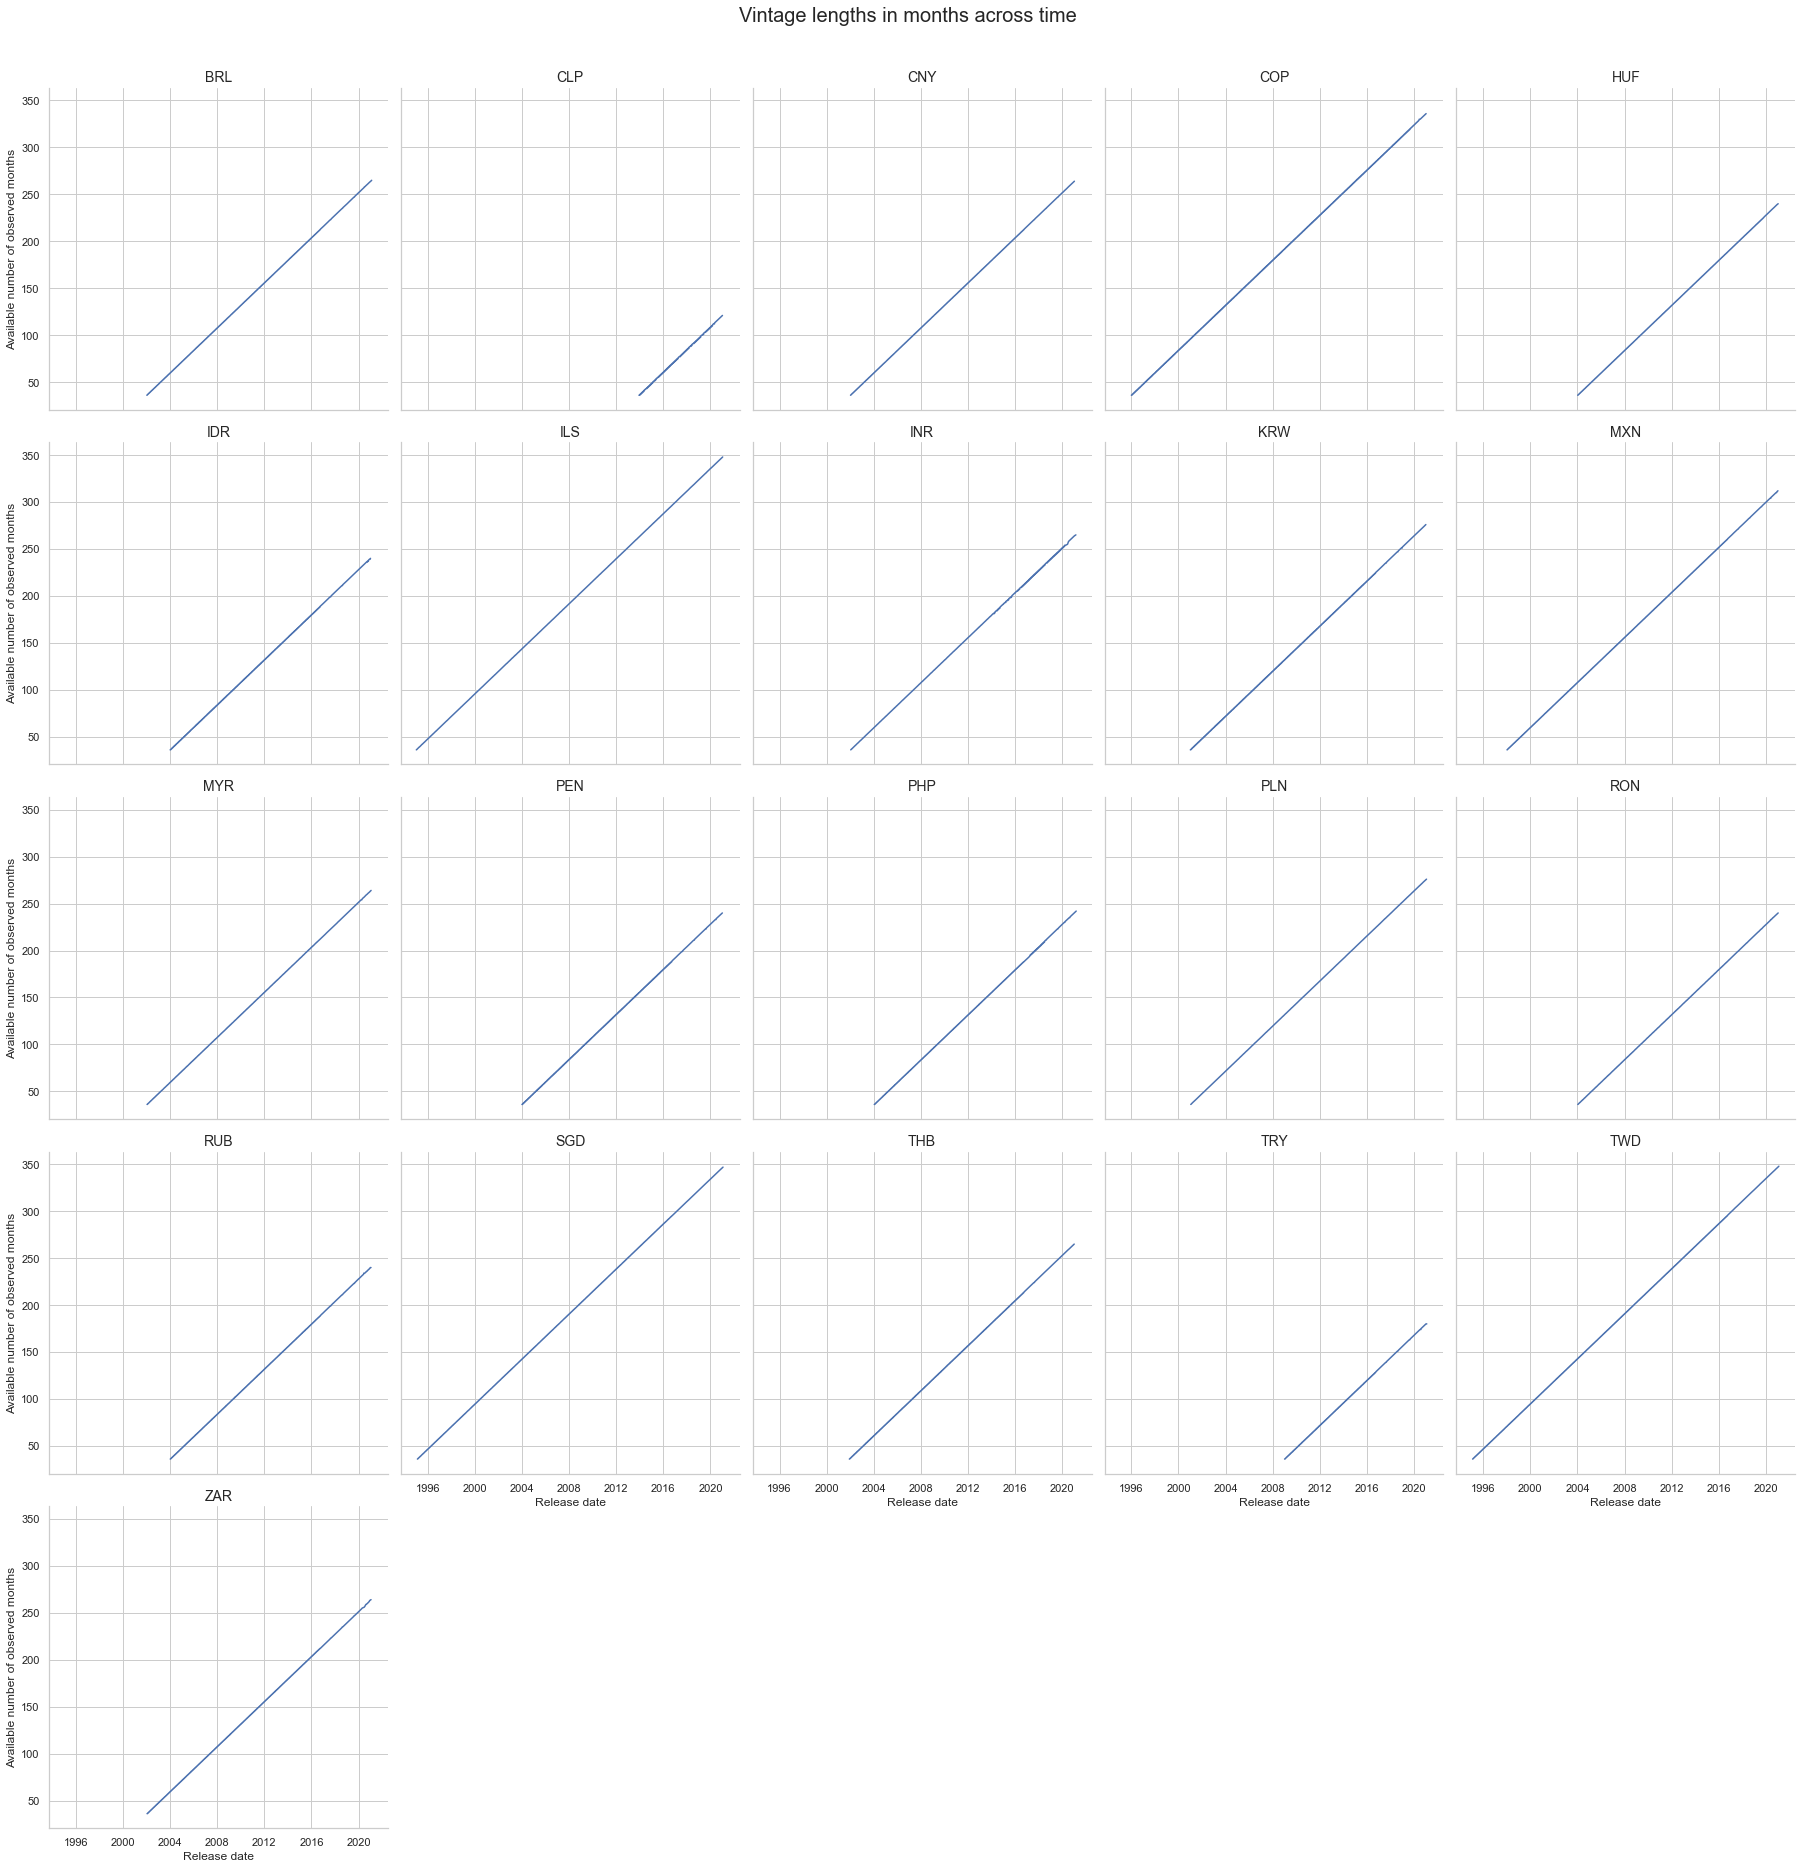

In [45]:
cidx = cids_ife2 & set(cids_em)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE2Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

### Vintage lines

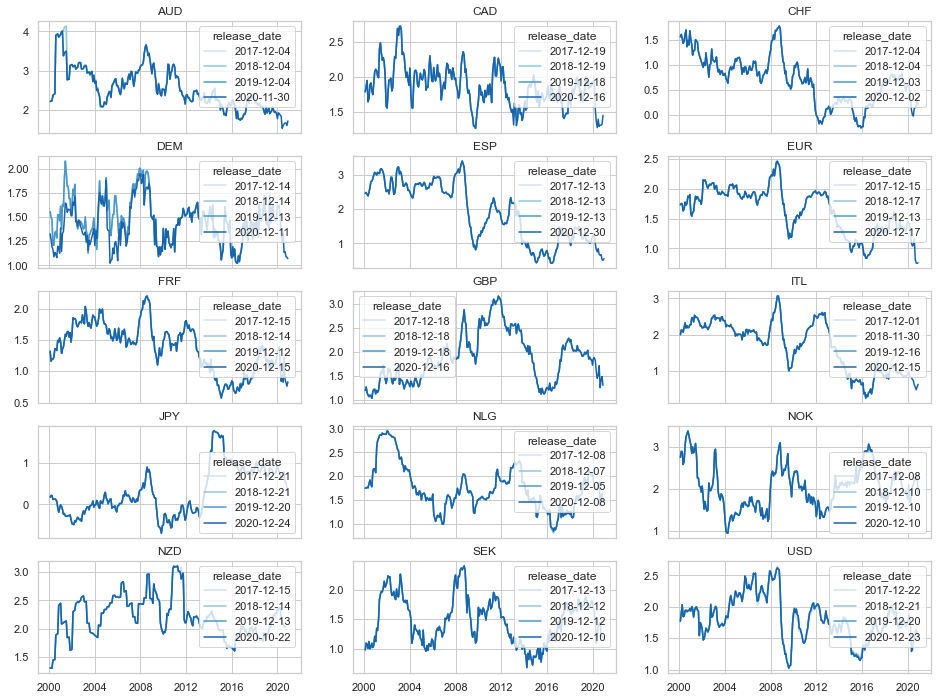

In [46]:
cidx = cids_ife2 & set(cids_dm)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE2Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 12))

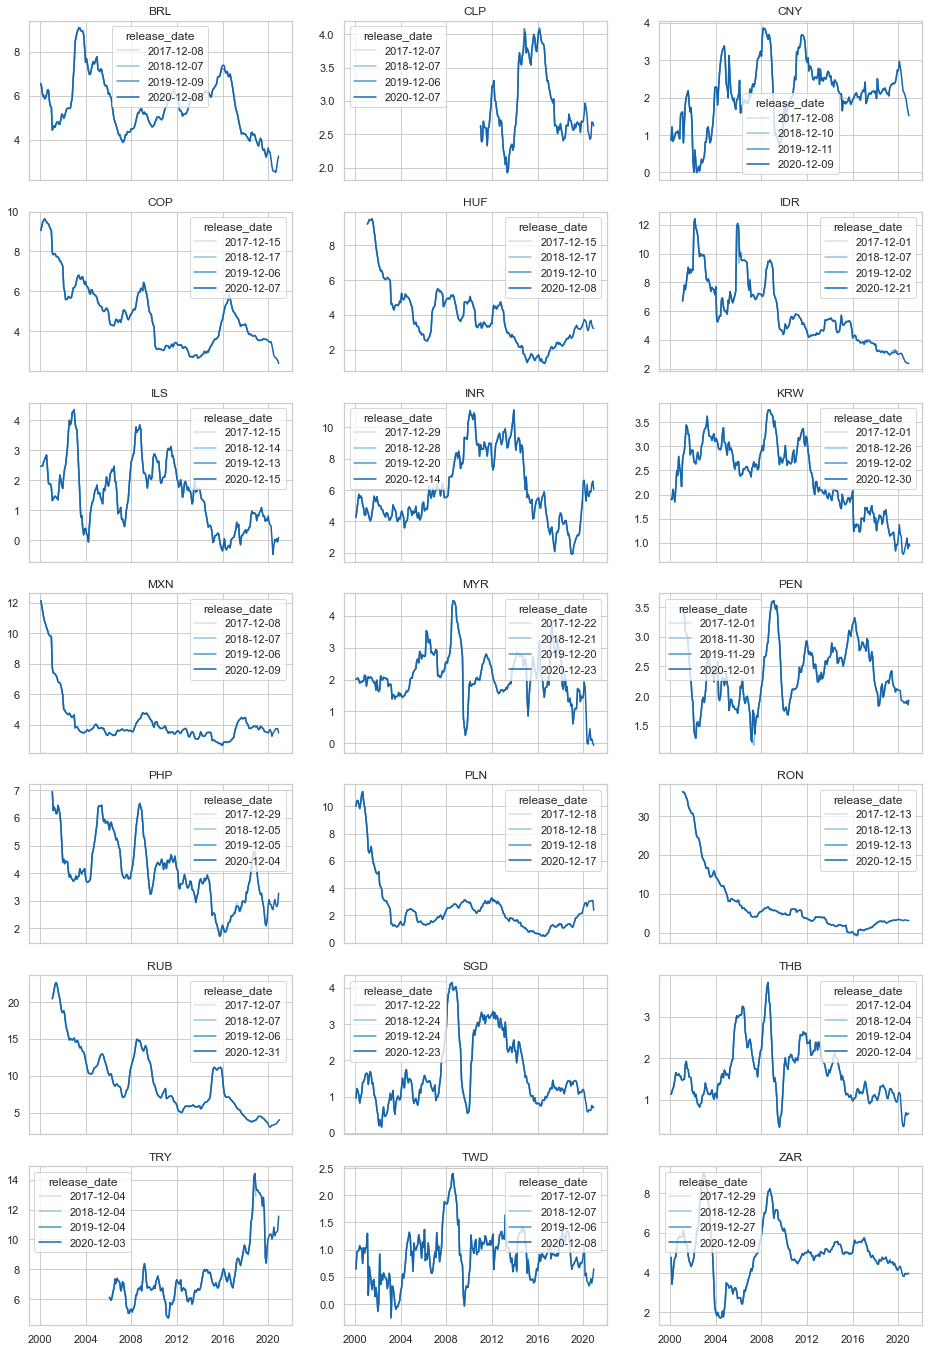

In [47]:
cidx = cids_ife2 & set(cids_em)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE2Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 24))

## Estimated 5-year ahead inflation expectation

### Vintage availability

In [48]:
cids_ife5 = set(dfm.loc[dfm['category_code']=='INFE5Y', 'cross_section'].unique())  # set of cross-sections in downloaded df
print('Cross sections outside the regular global set: ', cids_ife5 - set(cids)) 
print('Cross sections missing from regular global set: ', set(cids) - cids_ife5) 

Cross sections outside the regular global set:  set()
Cross sections missing from regular global set:  {'HKD', 'ARS'}


<function matplotlib.pyplot.show(*args, **kw)>

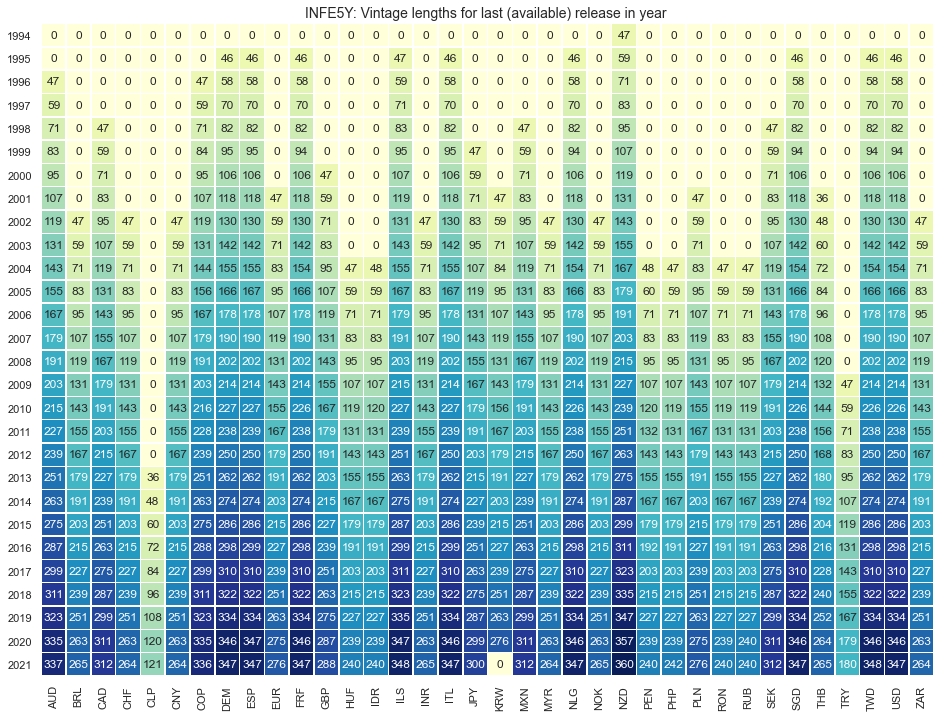

In [49]:
countmap('INFE5Y', 1990, (16, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

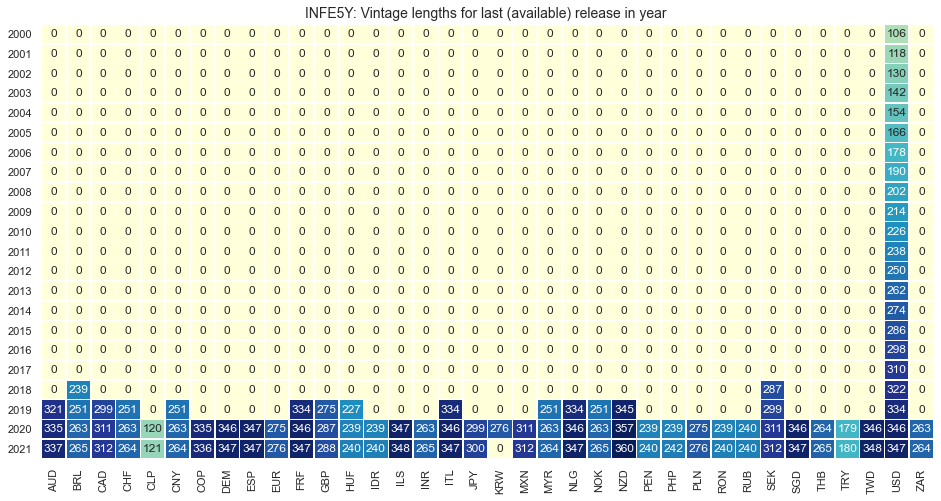

In [50]:
countmap('INFE5Y', 1990, (16, 8), trueVin=True)
plt.show

### Vintage consistency

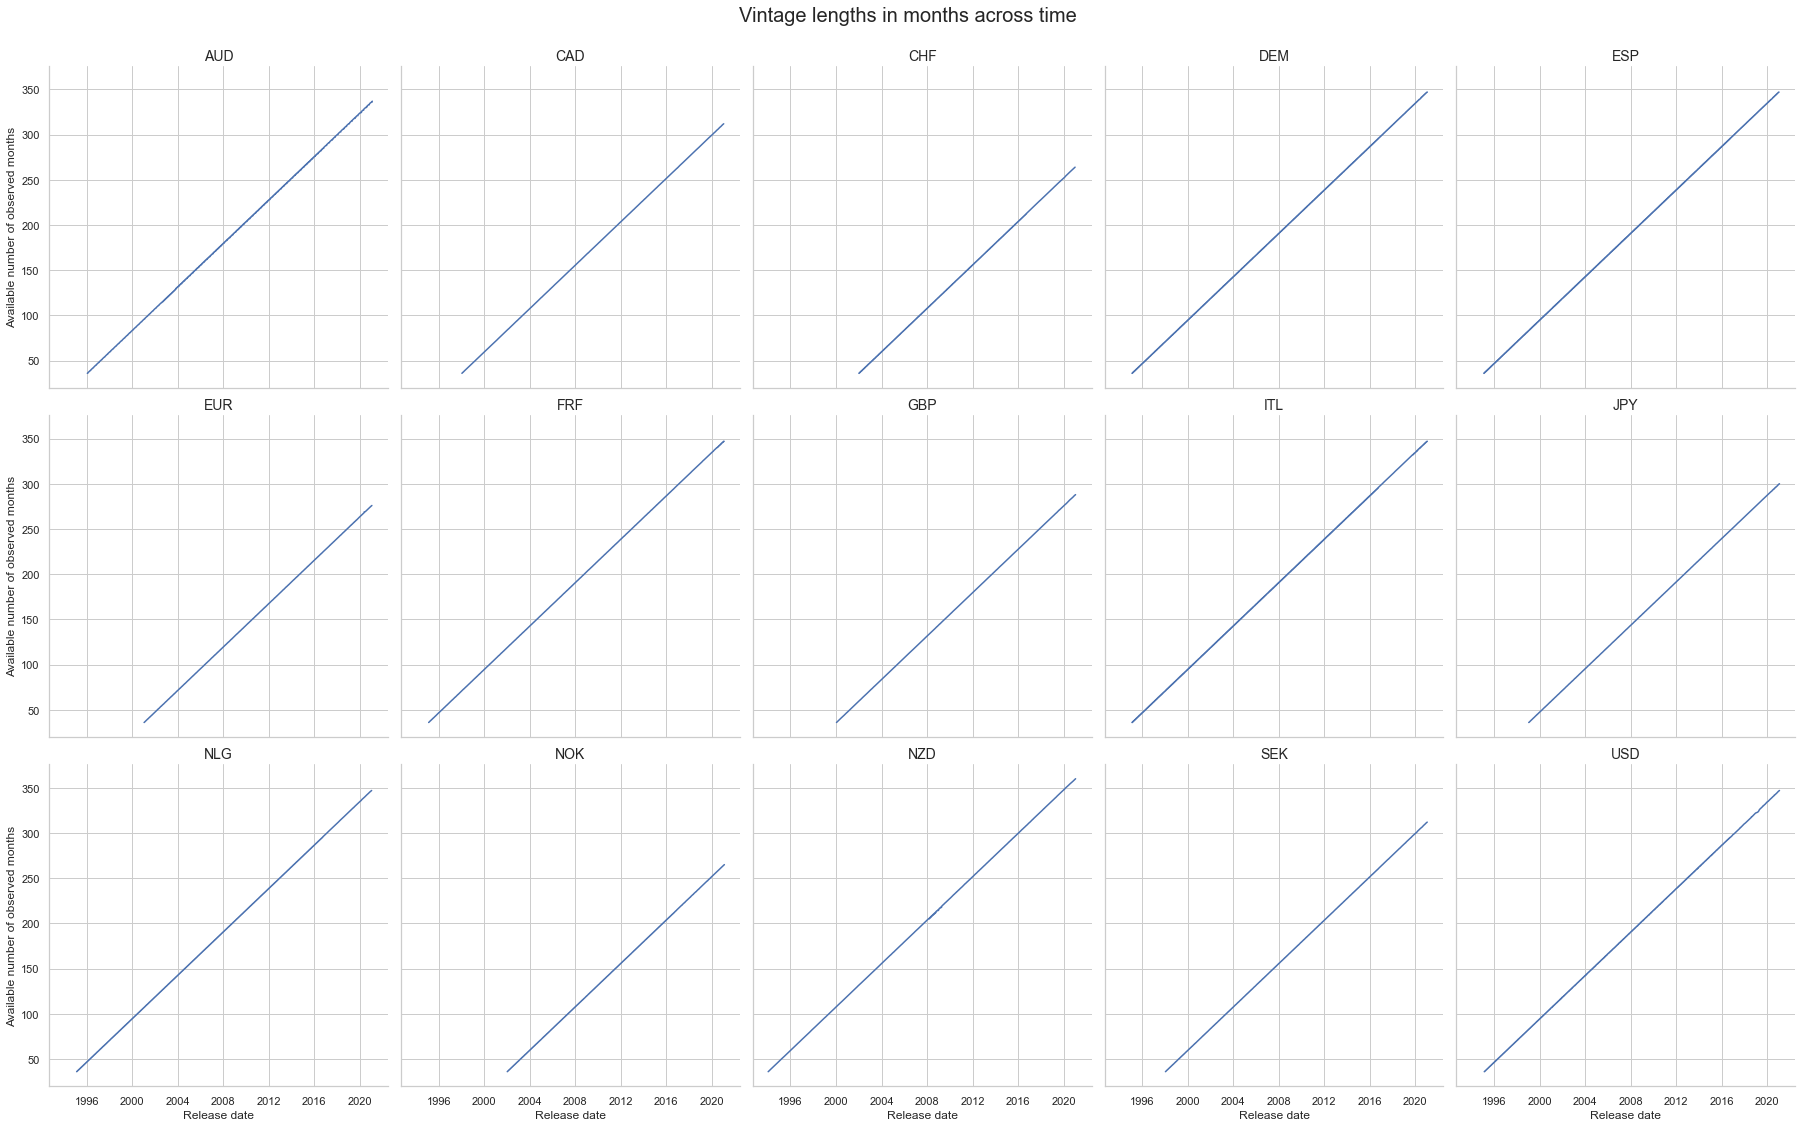

In [51]:
cidx = cids_ife5 & set(cids_dm)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE5Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

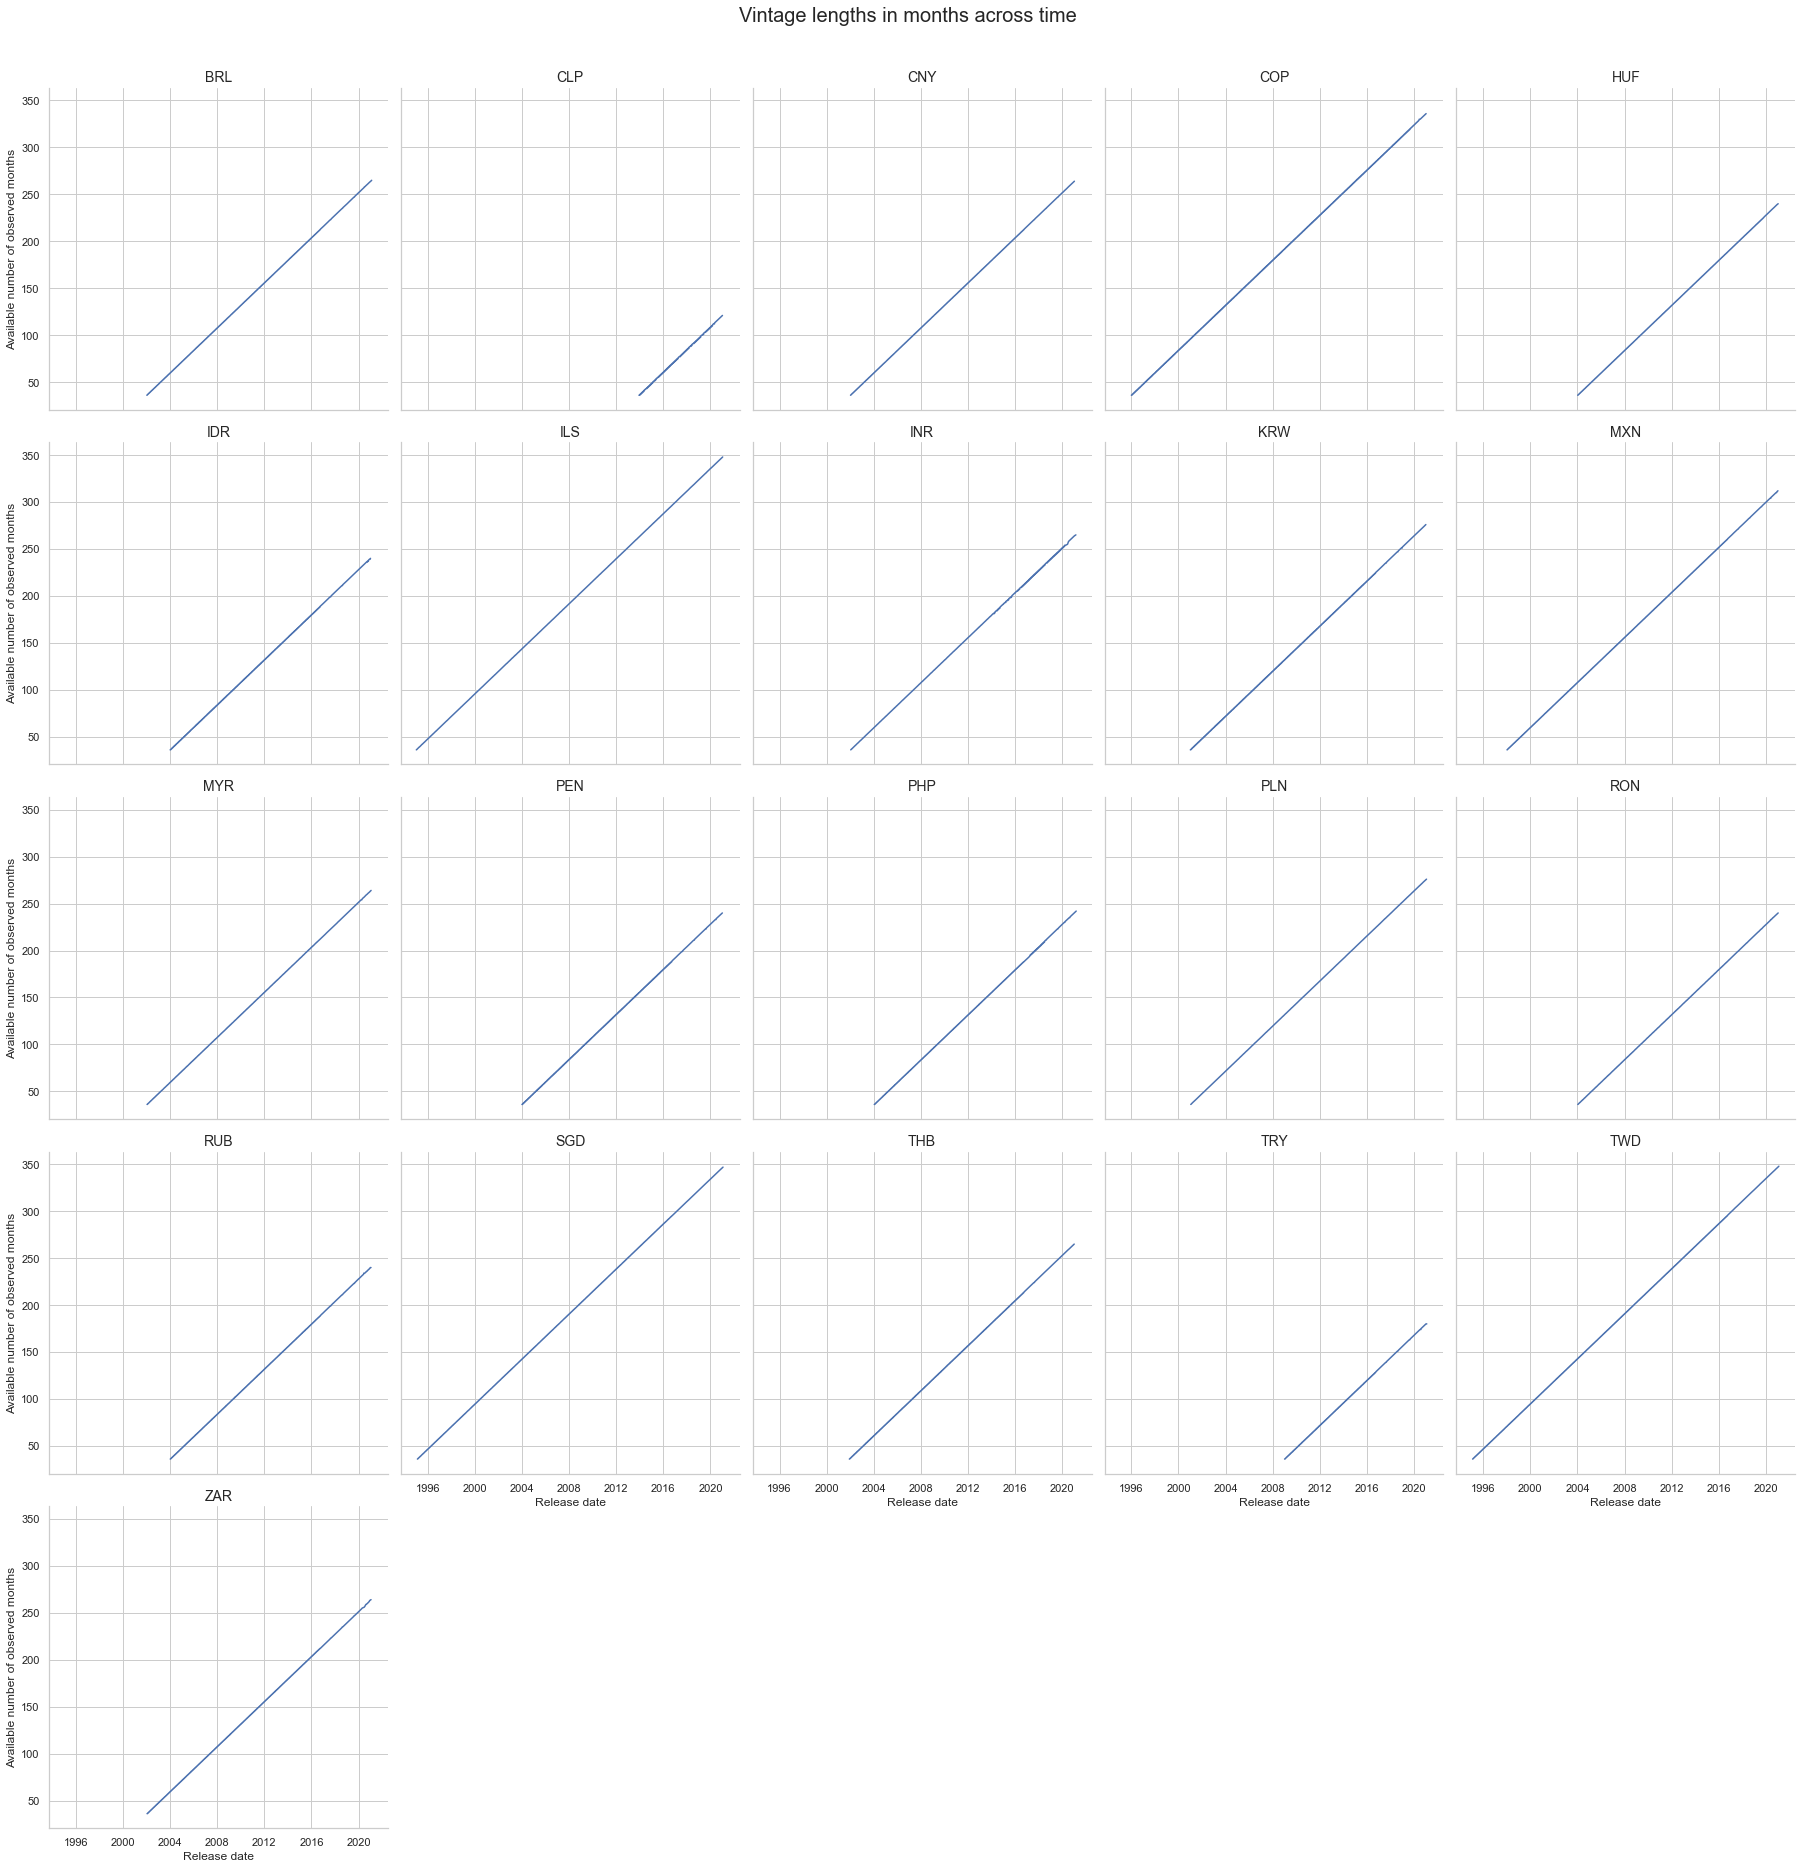

In [52]:
cidx = cids_ife5 & set(cids_em)
filt1 = dfm['cross_section'].isin(cidx)
filt2 = dfm['category_code'] == 'INFE5Y'

dfm_x = dfm.loc[(filt1 & filt2), ['cross_section', 'release_date', 'observation_date']]
dfm_x = dfm_x.groupby(['cross_section', 'release_date']).agg('count').reset_index()

fg = sns.relplot(x='release_date', y = 'observation_date', data=dfm_x, kind='line', col='cross_section', col_wrap=5)
(fg.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in months across time', y = 1.03, fontsize=20))
plt.show()

### Vintage lines

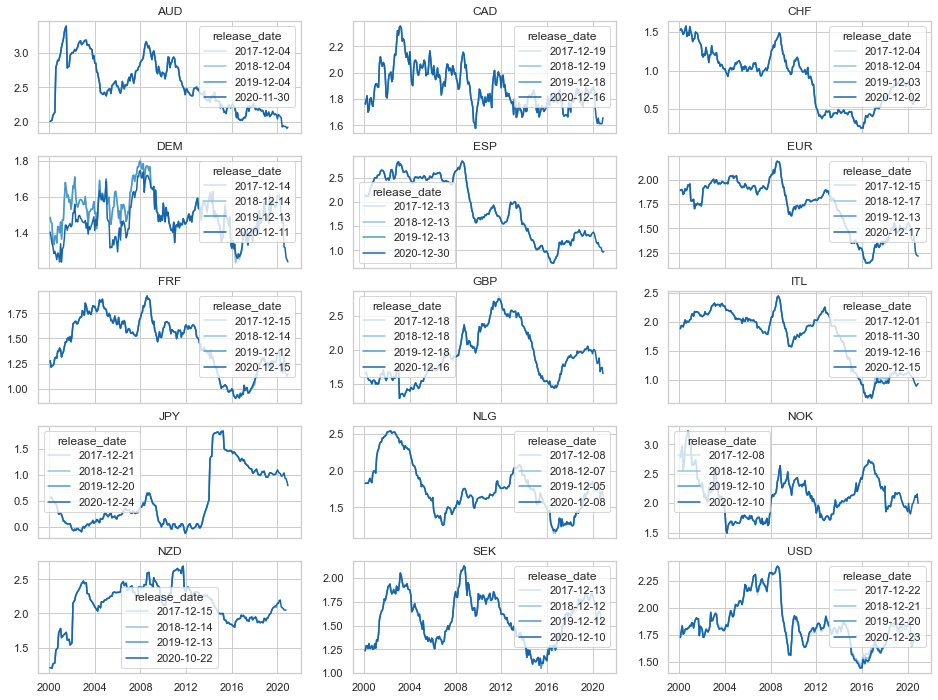

In [53]:
cidx = cids_ife5 & set(cids_dm)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE5Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 12))

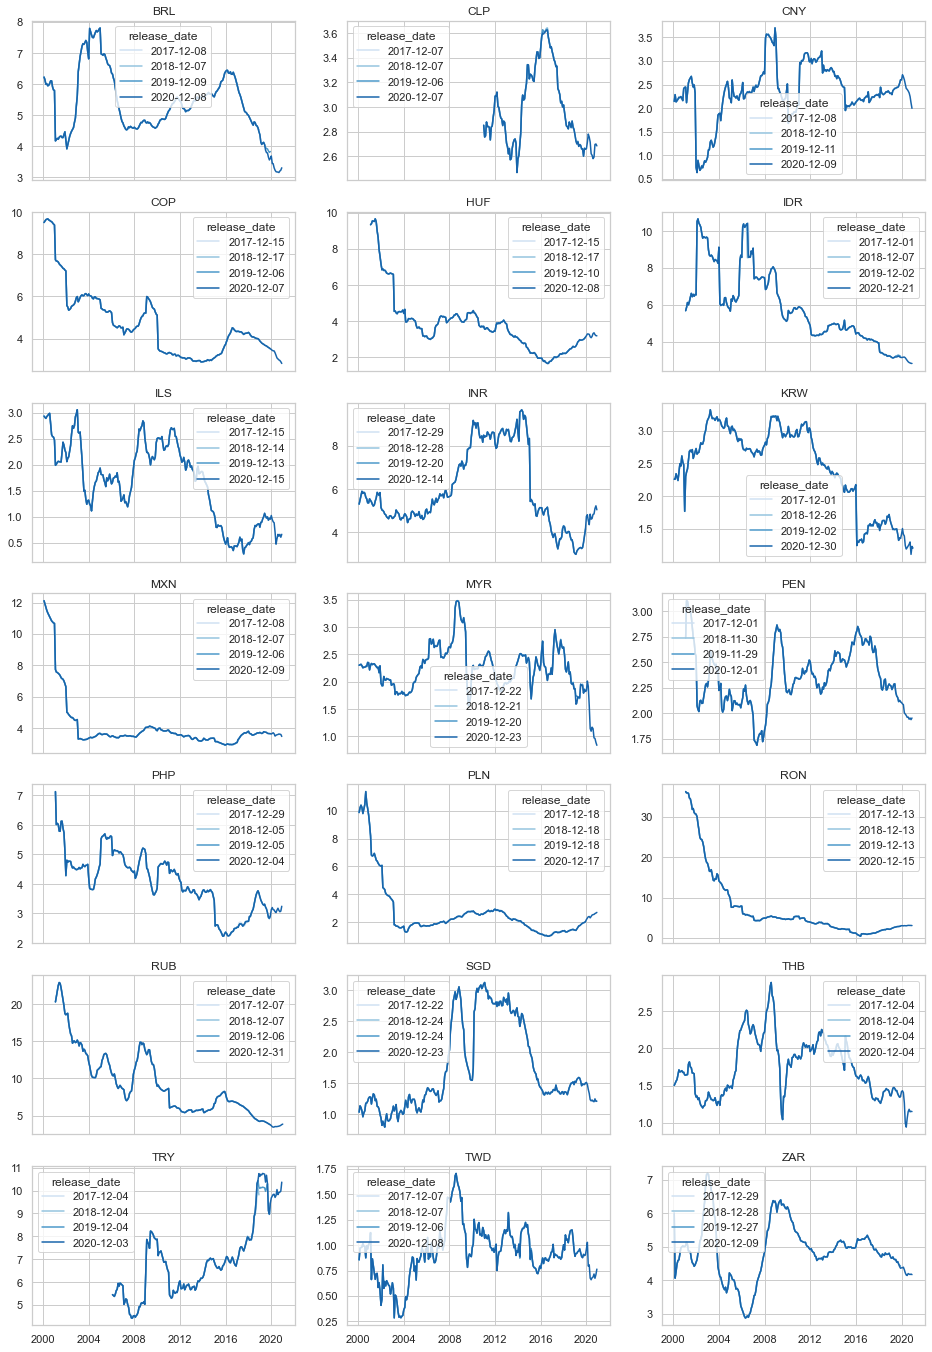

In [54]:
cidx = cids_ife5 & set(cids_em)
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']

filt1 = dfm['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm['category_code'] == 'INFE5Y'
filt3 = dfm['cross_section'].isin(cidx)
dfm_x = dfm[filt1 & filt2 & filt3]

revlines(dfm_x, pots=pots, ncols=3, size = (16, 24))

## Final vintage checkup

### Extract the last vintages

In [55]:
df_lasts = dfm.groupby(['cross_section', 'category_code'])['release_date'].max().reset_index()  # last releases
dfm_lv = pd.merge(df_lasts, dfm, how='left', on = ['cross_section', 'category_code', 'release_date'])  # last vintages
dfm_lv = dfm_lv[dfm_lv['observation_date'] > pd.to_datetime('2002-01-01')]

### Check the targets

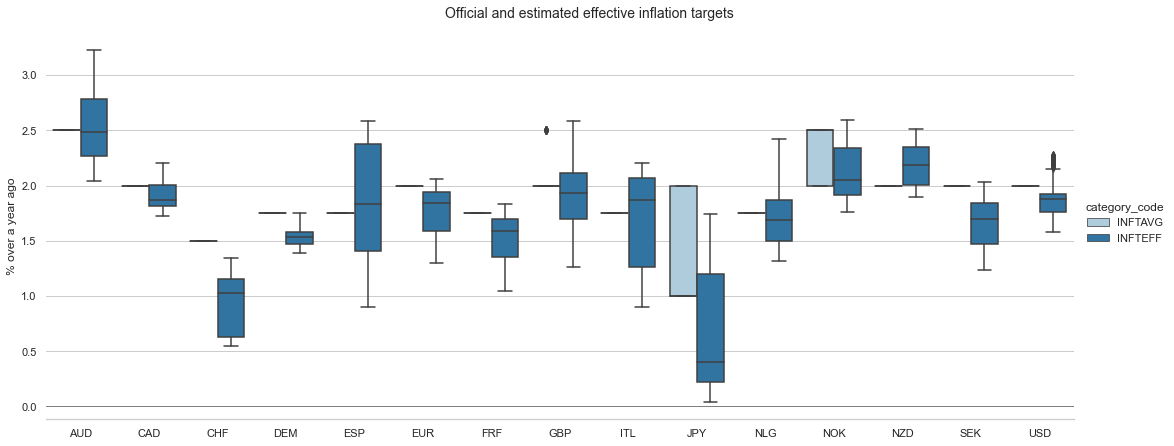

In [56]:
filt1 = dfm_lv['category_code'].isin(['INFTAVG', 'INFTEFF'])
filt2 = dfm_lv['cross_section'].isin(cids_dm)
dfm_lvx = dfm_lv[filt1 & filt2]
make_boxes(dfm_lvx, 'value', 'Official and estimated effective inflation targets', '% over a year ago')

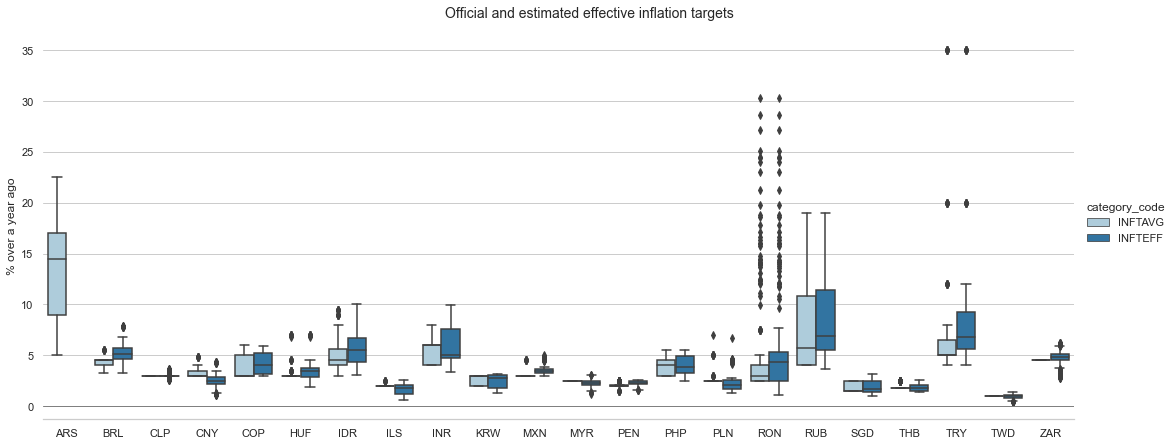

In [57]:
filt1 = dfm_lv['category_code'].isin(['INFTAVG', 'INFTEFF'])
filt2 = dfm_lv['cross_section'].isin(cids_em)
dfm_lvx = dfm_lv[filt1 & filt2]
make_boxes(dfm_lvx, 'value', 'Official and estimated effective inflation targets', '% over a year ago')

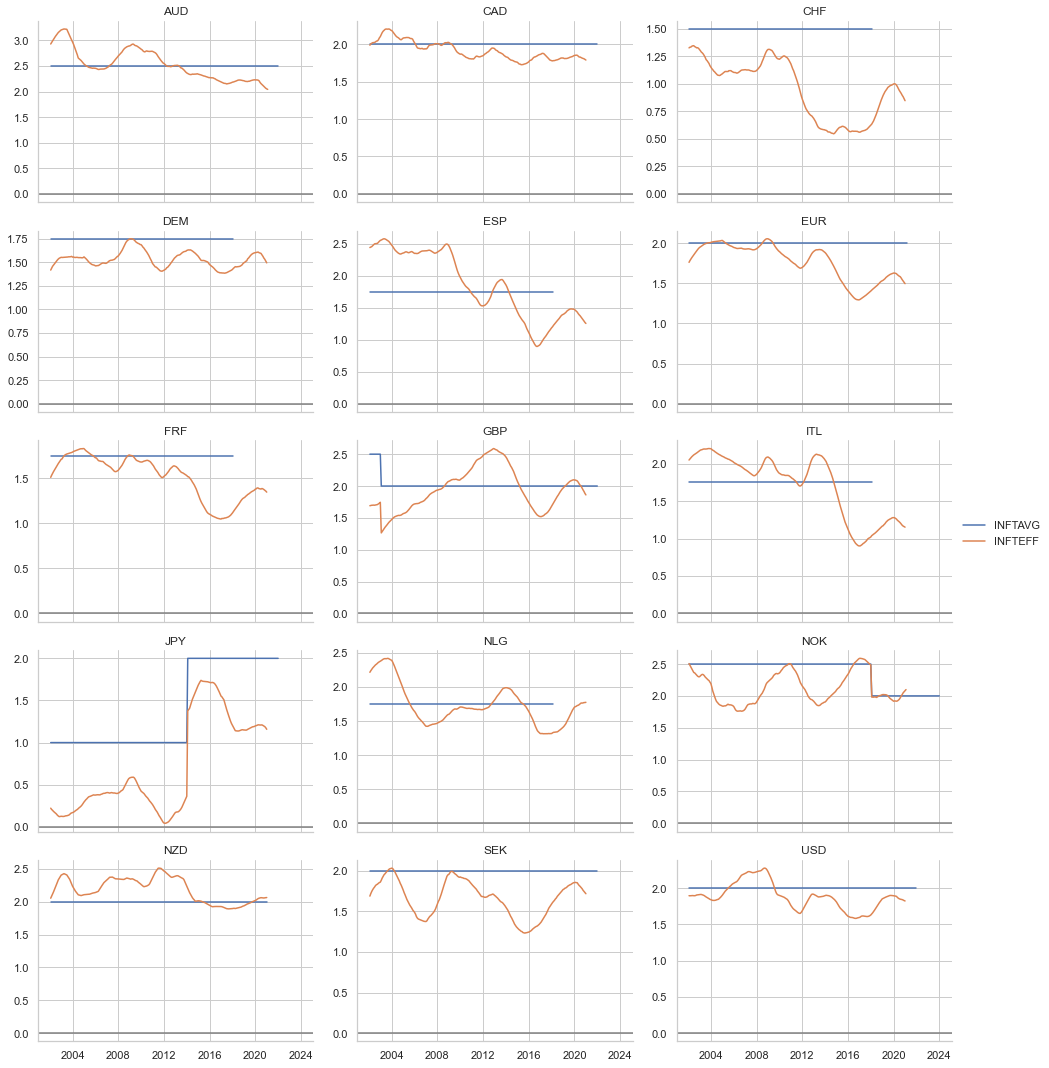

In [58]:
filt1 = dfm_lv['category_code'].isin(['INFTAVG', 'INFTEFF'])
filt2 = dfm_lv['cross_section'].isin(cids_dm)
dfm_lvx = dfm_lv[filt1 & filt2]
fg = sns.FacetGrid(dfm_lvx, col='cross_section', col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='observation_date', y='value', hue ='category_code')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

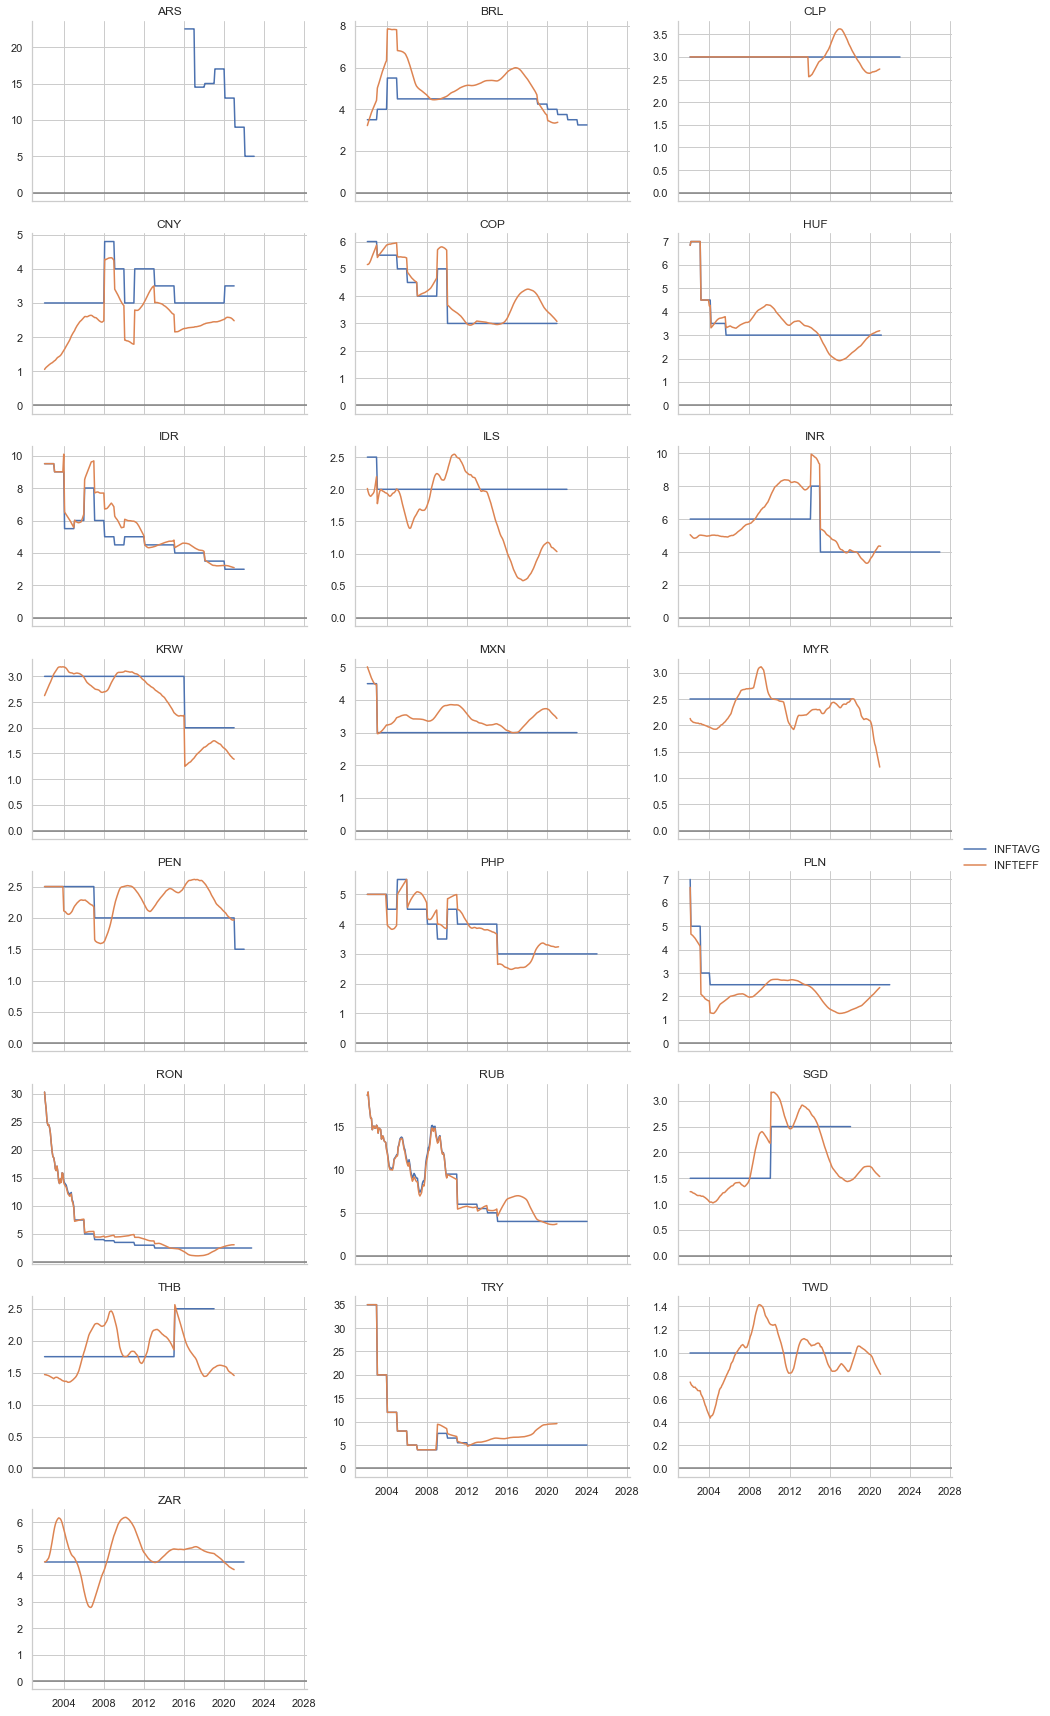

In [59]:
filt1 = dfm_lv['category_code'].isin(['INFTAVG', 'INFTEFF'])
filt2 = dfm_lv['cross_section'].isin(cids_em)
dfm_lvx = dfm_lv[filt1 & filt2]
fg = sns.FacetGrid(dfm_lvx, col='cross_section', col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='observation_date', y='value', hue ='category_code')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

### Check the expectations

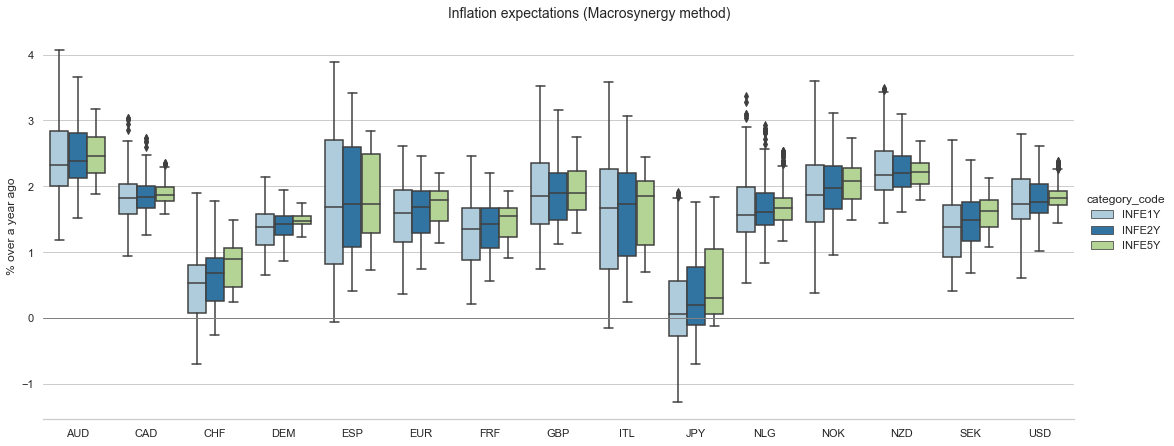

In [60]:
filt1 = dfm_lv['category_code'].isin(['INFE1Y', 'INFE2Y', 'INFE5Y'])
filt2 = dfm_lv['cross_section'].isin(cids_dm)
dfm_lvx = dfm_lv[filt1 & filt2]
make_boxes(dfm_lvx, 'value', 'Inflation expectations (Macrosynergy method)', '% over a year ago')

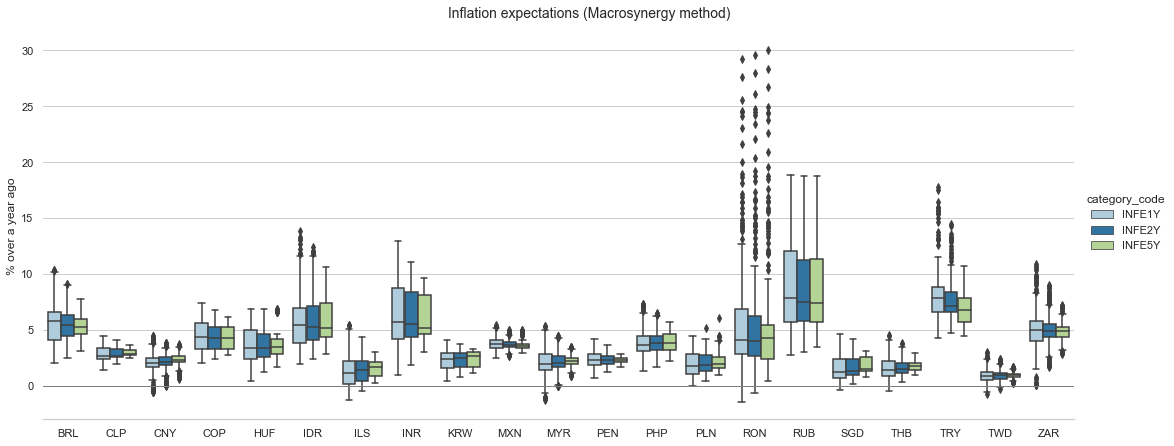

In [61]:
filt1 = dfm_lv['category_code'].isin(['INFE1Y', 'INFE2Y', 'INFE5Y'])
filt2 = dfm_lv['cross_section'].isin(cids_em)
dfm_lvx = dfm_lv[filt1 & filt2]
make_boxes(dfm_lvx, 'value', 'Inflation expectations (Macrosynergy method)', '% over a year ago')

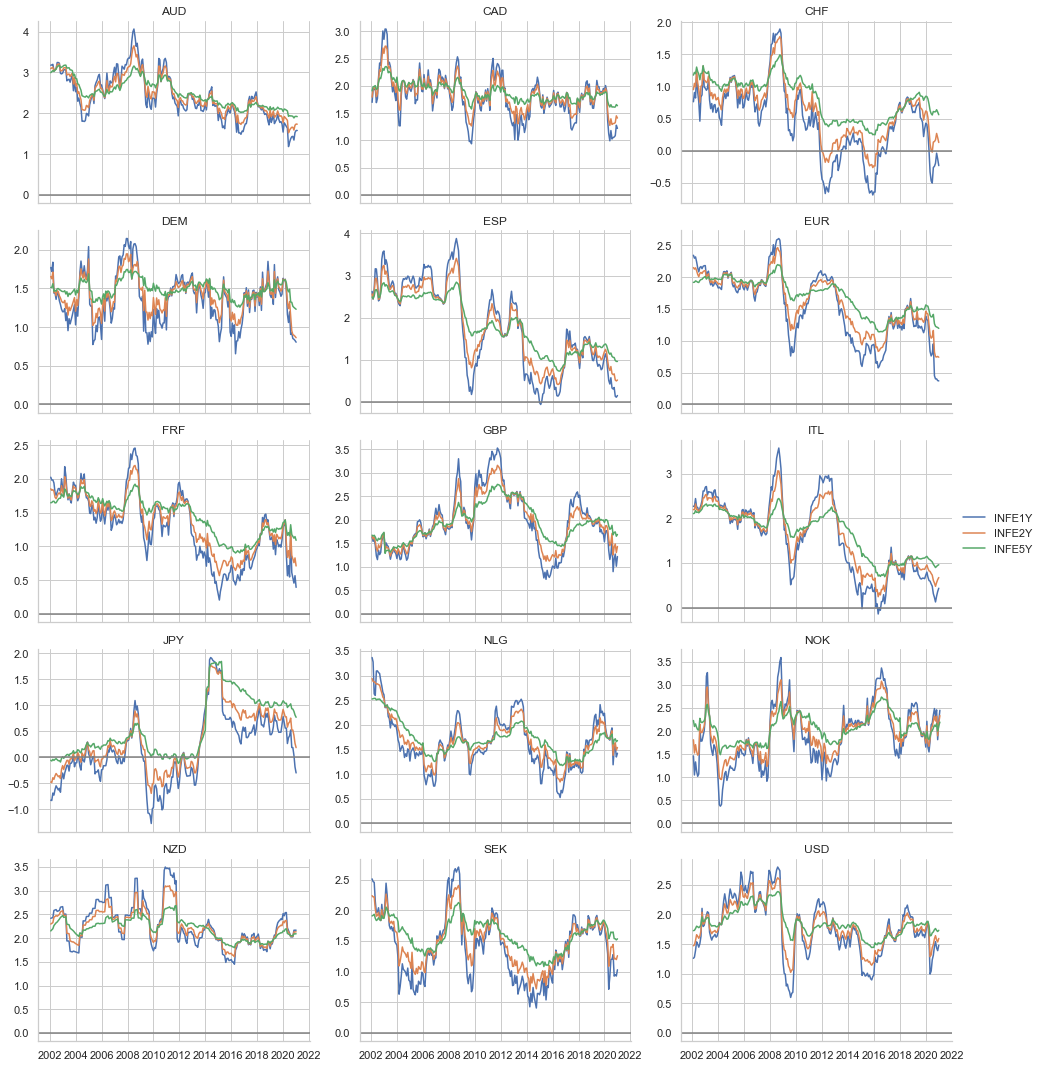

In [62]:
filt1 = dfm_lv['category_code'].isin(['INFE1Y', 'INFE2Y', 'INFE5Y'])
filt2 = dfm_lv['cross_section'].isin(cids_dm)
dfm_lvx = dfm_lv[filt1 & filt2]
fg = sns.FacetGrid(dfm_lvx, col='cross_section', col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='observation_date', y='value', hue ='category_code')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

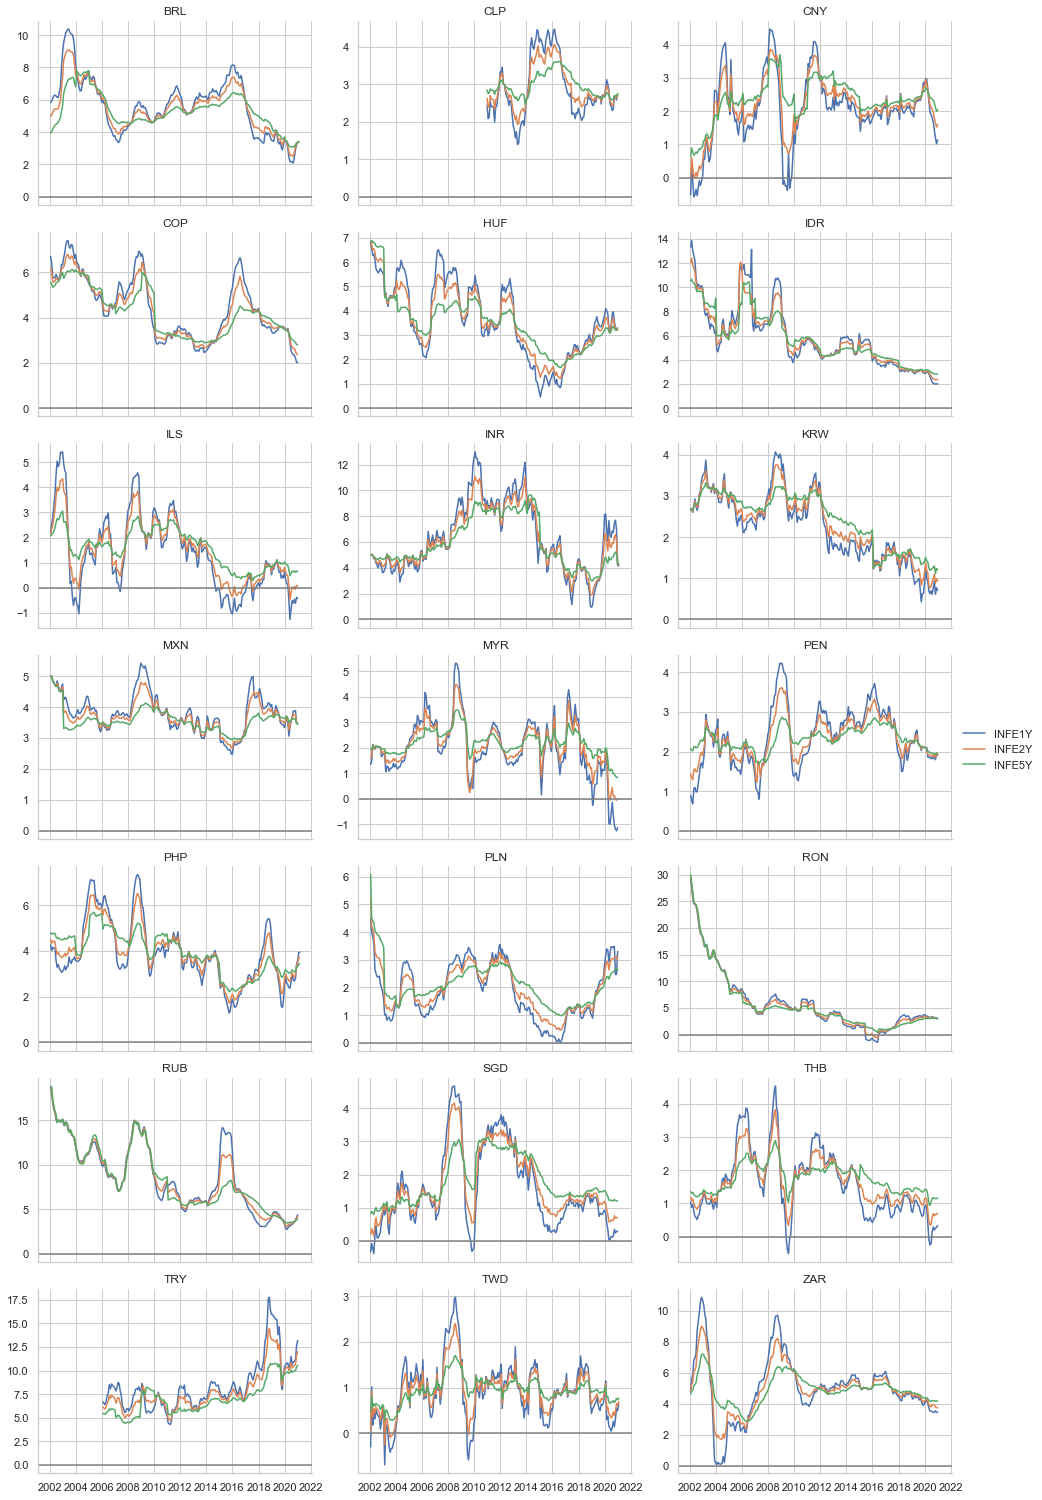

In [63]:
filt1 = dfm_lv['category_code'].isin(['INFE1Y', 'INFE2Y', 'INFE5Y'])
filt2 = dfm_lv['cross_section'].isin(cids_em)
dfm_lvx = dfm_lv[filt1 & filt2]
fg = sns.FacetGrid(dfm_lvx, col='cross_section', col_wrap = 3, sharey=False, aspect = 1.5)
fg.map_dataframe(sns.lineplot, x='observation_date', y='value', hue ='category_code')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.add_legend()
plt.show()

### Correlations

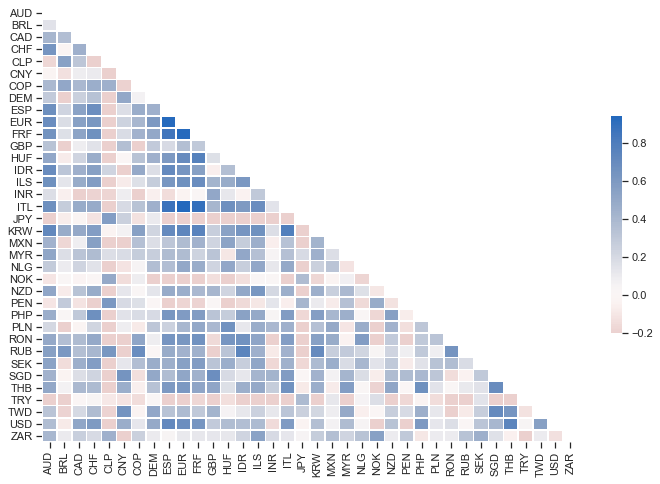

In [64]:
dfm_lvx = dfm_lv[dfm_lv['category_code'] == 'INFE1Y']
dfm_lvw = dfm_lvx.pivot(index='observation_date', columns='cross_section', values='value')

sns.set(style="ticks")  
corr = dfm_lvw.corr()  # compute correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
f, ax = plt.subplots(figsize=(12, 8))  # set up figure

sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set(xlabel='', ylabel='')
plt.show()